In [1]:
import numpy as np
import trace_gen as tg
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
import scipy.stats as ss

In [71]:
def load_trace_w(file):
    w = np.loadtxt(f'/opt/traces/{file}_r.txt', dtype=np.int32)
    w[:, 0] += 7
    w = tg.squash(tg.unroll(w // 8))
    return w

def load_trace_v(file):
    v = np.loadtxt(f'/mnt/sda/alibaba_block_traces_2020/{file}.txt', dtype=np.int64)
    v[:, 0] += 4095
    v = tg.squash(tg.unroll(v // 4096))
    return v

def type_b_run(w): 
    r = tg.TraceReconstructor(w)
    recon_w = r.gen_from_ird(len(w)//3)
    return recon_w

def type_b_run2(w, n): 
    r = tg.TraceReconstructor(w)
    recon_w = r.gen_from_ird(n)
    return recon_w

def type_a_run(M, n, f, p_irm):
    g = tg.TraceGenerator(M, n)
    recon_t = g.gen_from_pdf(f, p_irm)
    return recon_t
    
def mrc(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def calculate_error(reference, comparison):
    # Example error metric: Mean Absolute Error (MAE)
    if len(reference) > len(comparison):
        comparison = np.interp(np.linspace(0, 1, len(reference)), np.linspace(0, 1, len(comparison)), comparison)
    else:
        reference = np.interp(np.linspace(0, 1, len(comparison)), np.linspace(0, 1, len(reference)), reference)
    return np.mean(np.abs(reference - comparison))

def plot_mrcs(cs, lrus, names, title, location='upper left'):
    if 'v' in title:
        title = title.replace('v', 'volume')
    cs_normalized = [c / c.max() for c in cs]
    palette = sns.color_palette()
    fig, ax = plt.subplots()

    # Calculate error metrics
    errors = [0]  # The first one is the reference, so error is 0
    for i in range(1, len(lrus)):
        error = calculate_error(lrus[0], lrus[i])
        errors.append(error)
    
    for i in range(len(cs)):
        if i == 0:
            linestyle = '-'
            marker = ''
            linewidth = 3
        elif i == 1:
            linestyle = '--'
            marker = '+'
            linewidth = 3
        else:
            linestyle = '--'
            marker = ''
            linewidth = 3
        
        label = f"{names[i]}"
        ax.plot(cs_normalized[i], lrus[i], linestyle + marker, label=label, linewidth=linewidth, color=palette[i], alpha=0.8)

    ax.set_xlabel('Normalized Cache size (C)', fontsize=28)
    ax.set_ylabel('Hit rate', fontsize=28)
    ax.legend(loc=location, fontsize=16, framealpha=0)
    ax.set_title(title, fontsize=28)
    ax.tick_params(axis='both',  labelsize=20)

    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))

    plt.show()
    print(errors)



In [9]:
def mae(hr1, hr2):
    return np.mean(np.abs(hr1 - hr2))
def norm(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [5]:
f82 = tg.fgen(100, [12,13,19],1e-3)

In [6]:
import multiprocessing
import psutil
import time
import os

def monitor(func, *args):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    def target(return_dict, idx, *args):
        process = psutil.Process(os.getpid())
        print(f"Process ID: {os.getpid()}")
        
        start_time = time.time()
        
        result = func(*args) 
        
        end_time = time.time()
        
        # # CPU times
        # cpu_times = process.cpu_times()
        # user_time = cpu_times.user
        # system_time = cpu_times.system

        # Memory usage in MB
        memory_info = process.memory_info()
        memory_usage = memory_info.rss / 1024 ** 2  # Convert from bytes to MB

        # Elapsed time
        elapsed_time = end_time - start_time

        # Print the resource usage
        print(f"Memory Usage: {memory_usage:.2f} MB")
        # print(f"User Time: {user_time:.2f} seconds")
        # print(f"System Time: {system_time:.2f} seconds")
        print(f"Elapsed Time: {elapsed_time:.2f} seconds")

        # Store the result in the shared dictionary
        return_dict[idx] = result

    # Run the target function in a new process
    p = multiprocessing.Process(target=target, args=(return_dict, 0, *args))
    p.start()
    p.join()

    # Retrieve the result from the shared dictionary
    return return_dict[0]


In [7]:
w82 = load_trace_w('w82')

In [8]:
tb_w82 = monitor(type_b_run, w82)# use trace length // 3 for this measurement, but the actual plot of MRC later on uses the trace we created before with length // 2, due to the shorter trace doesn not capture the full MRC.

Process ID: 8365


Memory Usage: 226.38 MB
Elapsed Time: 36.74 seconds


In [9]:
ta1_w82 = monitor(type_a_run, 100, 10000, f82, 0.2)


Process ID: 8390


Memory Usage: 195.88 MB
Elapsed Time: 0.06 seconds


In [79]:
co, hro = mrc(w82)
co_tb, hro_tb = mrc(tb_w82)
co_ta1, hro_ta1 = mrc(ta1_w82)


In [80]:
ta2_w82 = monitor(type_a_run, 1000, 100000, f82, 0.2)
co_ta2, hro_ta2 = mrc(ta2_w82)
ta3_w82 = monitor(type_a_run, 10000, 1000000, f82, 0.2)
co_ta3, hro_ta3 = mrc(ta3_w82)

Process ID: 9103


Memory Usage: 454.31 MB
Elapsed Time: 0.60 seconds
Process ID: 9127
Memory Usage: 455.88 MB
Elapsed Time: 6.22 seconds


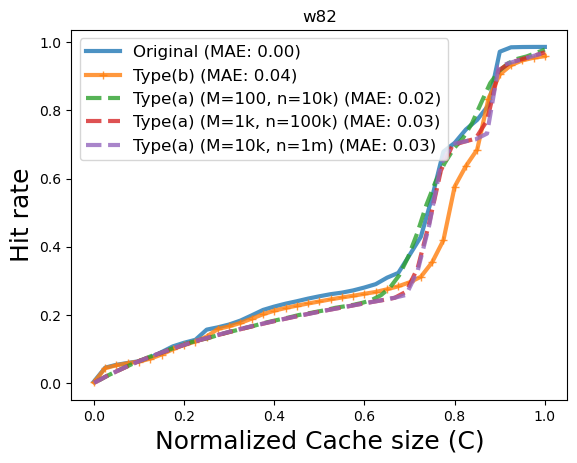

In [39]:
plot_mrcs([co, co_tb, co_ta1, co_ta2, co_ta3], [hro, hro_tb, hro_ta1, hro_ta2, hro_ta3], ['Original', 'Type(b)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'], 'w82')


In [3]:
def plot_mrc_cost(cs, lrus, names, location='upper left', gen_mem=None, gen_time=None):
    cs_normalized = [c / c.max() for c in cs]
    palette_mrcs = sns.color_palette()  # Default palette for MRCs
    palette_mem_time = sns.color_palette("dark")  # "dark" palette for Memory and Time usage
    
    # Create a figure with two subplots: one for the MRCs and one for the memory/time usage
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plotting the MRCs
    ax = axs[0]
    errors = [0]  # The first one is the reference, so error is 0
    for i in range(1, len(lrus)):
        error = calculate_error(lrus[0], lrus[i])
        errors.append(error)
    
    for i in range(len(cs)):
        if i == 0:
            linestyle = '-'
            marker = ''
            linewidth = 3
        elif i == 1 or i == 2:
            linestyle = '-'
            marker = '+'
            linewidth = 3
        else:
            linestyle = '--'
            marker = ''
            linewidth = 3
        
        label = f"{names[i]} (MAE: {errors[i]:.2f})"
        ax.plot(cs_normalized[i], lrus[i], linestyle + marker, label=label, linewidth=linewidth, color=palette_mrcs[i], alpha=0.8)

    ax.set_xlabel('Normalized Cache size (C)', fontsize=18)
    ax.set_ylabel('Hit rate', fontsize=18)
    ax.legend(loc=location, fontsize=14)
    ax.set_title("MRCs", fontsize=18)
    
    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
    
    # Plotting the memory and time usage
    ax2 = axs[1]
    indices = np.arange(len(gen_mem))
    bar_width = 0.35
    
    bars1 = ax2.bar(indices, gen_mem, bar_width, label='Memory (MB)', alpha=0.7, color=palette_mem_time[0])
    ax2.set_xlabel('Trace-generation Type', fontsize=18)
    ax2.set_ylabel('Memory (MB)', fontsize=18)
    ax2.set_title('Memory and Time Usage', fontsize=18)
    ax2.set_xticks(indices)
    ax2.set_xticklabels(names[1:], rotation=20, ha='right', fontsize=12)
    
    # Add a second y-axis for time usage
    ax3 = ax2.twinx()
    ax3.plot(indices, gen_time, label='Time (s)', marker='o', linestyle='-', linewidth=2, color=palette_mem_time[1])
    ax3.set_ylabel('Time (s)', fontsize=18)
    
    # Combine legends from ax2 and ax3
    handles_mem = [bars1]  # Memory usage bar
    handles_time, labels_time = ax3.get_legend_handles_labels()

    handles_combined = handles_mem + handles_time
    labels_combined = ['Memory (MB)'] + labels_time
    
    ax2.legend(handles_combined, labels_combined, loc='upper right', fontsize=14, bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()


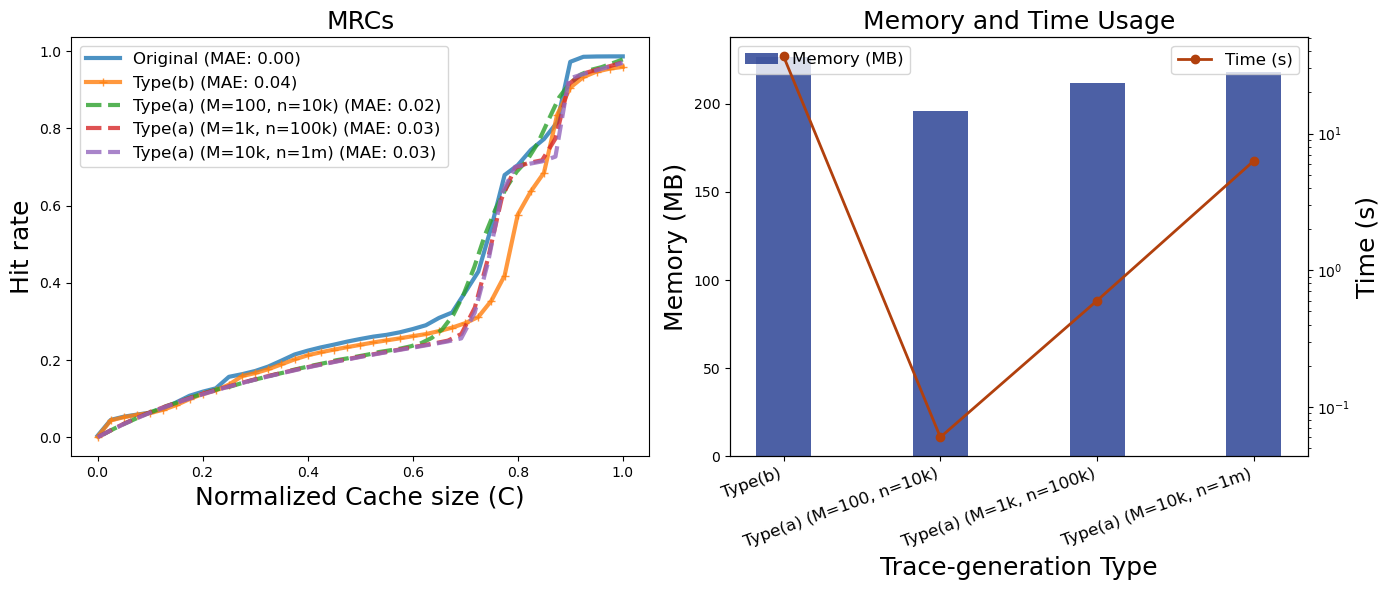

In [81]:

# Example usage:
w82_gen_mem = [226.38, 195.88, 211.73, 218.11]
w82_gen_time = [36.74, 0.06, 0.60, 6.32]

plot_mrc_cost([co, co_tb, co_ta1, co_ta2, co_ta3], 
          [hro, hro_tb, hro_ta1, hro_ta2, hro_ta3], 
          ['Original', 'Type(b)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'],
          location='best',
          w82_gen_mem=w82_gen_mem, 
          w82_gen_time=w82_gen_time)



In [ ]:
# w44, w82, v521, v538, v766

In [66]:
# w44
w44 = load_trace_w('w44')
tb_w44 = monitor(type_b_run, w44)

Process ID: 8740
Memory Usage: 500.43 MB
Elapsed Time: 115.27 seconds


In [71]:
f44 = tg.fgen(30, [9,13,17,19],2.5e-2)
ta1_w44 = monitor(type_a_run, 100, 10000, f44, 0)


Process ID: 8913


Memory Usage: 432.77 MB
Elapsed Time: 0.03 seconds


In [72]:
ta2_w44 = monitor(type_a_run, 1000, 100000, f44, 0)
ta3_w44 = monitor(type_a_run, 10000, 1000000, f44, 0)

Process ID: 8937


Memory Usage: 432.82 MB
Elapsed Time: 0.30 seconds
Process ID: 8961
Memory Usage: 434.47 MB
Elapsed Time: 3.15 seconds


In [75]:

w44_gen_mem = [500.43, 432.75, 432.81, 432.83]
w44_gen_time = [115.27, 0.03, 0.30, 3.15]
co, hro = mrc(w44)
co_tb = np.loadtxt(f'../data/recon/w44_c.txt', dtype=np.int32)
hro_tb = np.loadtxt(f'../data/recon/w44_ird_recon_lru_hr.txt', dtype=np.float32)
co_ta1, hro_ta1 = mrc(ta1_w44)
co_ta2, hro_ta2 = mrc(ta2_w44)
co_ta3, hro_ta3 = mrc(ta3_w44)


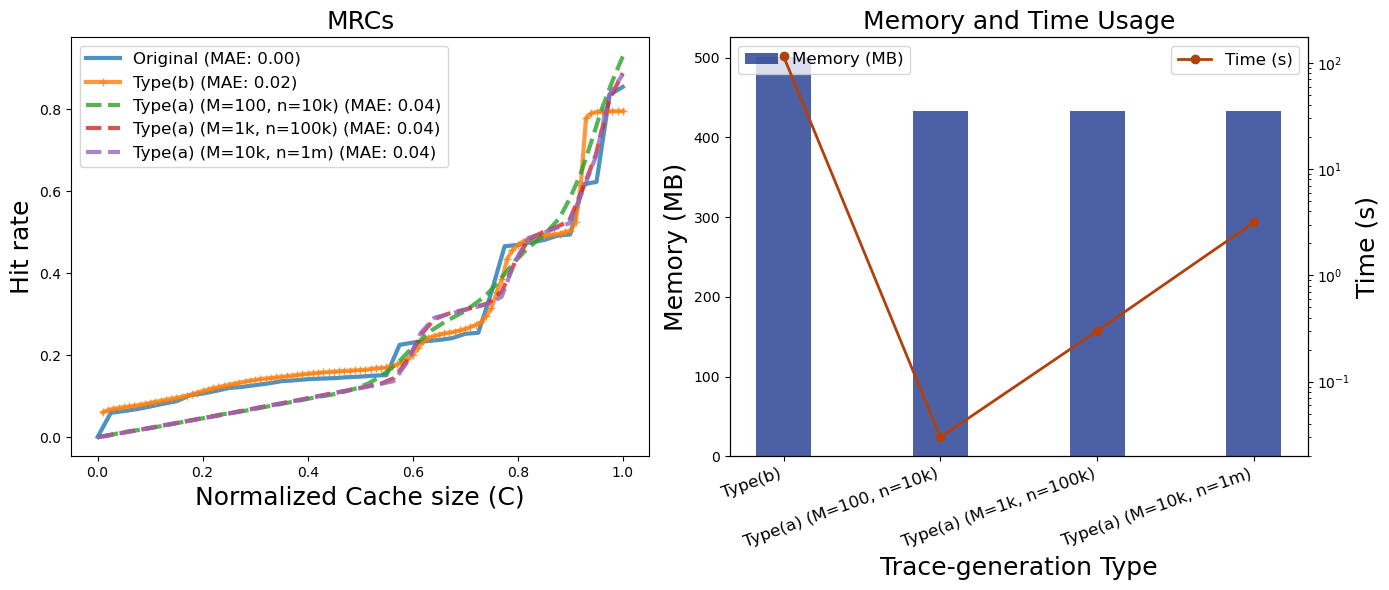

In [78]:
plot_mrc_cost([co, co_tb, co_ta1, co_ta2, co_ta3], 
          [hro, hro_tb, hro_ta1, hro_ta2, hro_ta3], 
          ['Original', 'Type(b)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'],
          location='best',
          w82_gen_mem=w44_gen_mem, 
          w82_gen_time=w44_gen_time)

In [83]:
# v538
def parse_trace(file, start_row, num_rows):
    file_path = f'/mnt/sda/alibaba_block_traces_2020/{file}.txt'
    
    # Print file path for debugging
    print(f"Reading file: {file_path}")
    
    # Try to load the data
    try:
        trace = np.loadtxt(file_path, skiprows=start_row, max_rows=num_rows, dtype=np.int64)
    except Exception as e:
        print(f"Error reading the file: {e}")
        raise
    
    # Print the shape of the trace array
    print(f"Shape of trace array: {trace.shape}")
    
    # Check if trace is 2D
    if trace.ndim != 2 or trace.shape[1] < 2:
        raise ValueError(f"Expected 2D array with at least 2 columns, but got shape {trace.shape}")
    
    trace[:, 0] += 4095
    trace = tg.squash(tg.unroll(trace // 4096))
    return trace

v538 = parse_trace('volume538', 0, 1000000)
tb_v538 = monitor(type_b_run, v538)

Reading file: /mnt/sda/alibaba_block_traces_2020/volume538.txt
Shape of trace array: (1000000, 2)
Process ID: 9207
Memory Usage: 5585.68 MB
Elapsed Time: 579.63 seconds


In [3]:
import multiprocessing
import psutil
import time
import os

def monitor(func, *args):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    def target(return_dict, idx, *args):
        process = psutil.Process(os.getpid())
        print(f"Process ID: {os.getpid()}")
        
        start_time = time.time()
        
        result = func(*args) 
        
        end_time = time.time()

        memory_info = process.memory_info()
        memory_usage = memory_info.rss / 1024 ** 2  # Convert from bytes to MB

        elapsed_time = end_time - start_time

        print(f"Memory Usage: {memory_usage:.2f} MB")
        # print(f"User Time: {user_time:.2f} seconds")
        # print(f"System Time: {system_time:.2f} seconds")
        print(f"Elapsed Time: {elapsed_time:.2f} seconds")

        # Store the result in the shared dictionary
        return_dict[idx] = result

    p = multiprocessing.Process(target=target, args=(return_dict, 0, *args))
    p.start()
    p.join()

    return return_dict[0]

In [5]:
w44 = load_trace_w('w44')
w44_tb = monitor(type_b_run2, w44, 1000000)

Process ID: 5907
Memory Usage: 288.22 MB
Elapsed Time: 35.84 seconds


In [6]:
np.savetxt(f'../data/performance/w44_tb_1m.txt', w44_tb, fmt='%d')

In [7]:
f44 = tg.fgen(30, [9,13,17,19],2.5e-2)
ta1_w44 = monitor(type_a_run, 100, 10000, f44, 0)
ta2_w44 = monitor(type_a_run, 1000, 100000, f44, 0)
ta3_w44 = monitor(type_a_run, 10000, 1000000, f44, 0)
np.savetxt(f'../data/performance/w44_ta_10k.txt', ta1_w44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_100k.txt', ta2_w44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_1m.txt', ta3_w44, fmt='%d')

Process ID: 6177
Memory Usage: 261.45 MB
Elapsed Time: 0.03 seconds
Process ID: 6201
Memory Usage: 261.51 MB
Elapsed Time: 0.29 seconds
Process ID: 6225
Memory Usage: 262.50 MB
Elapsed Time: 3.04 seconds


In [8]:
c_44, hr_44 = mrc(w44)
c_tb_44, hr_tb_44 = mrc(w44_tb)
c_ta1_44, hr_ta1_44 = mrc(ta1_w44)
c_ta2_44, hr_ta2_44 = mrc(ta2_w44)
c_ta3_44, hr_ta3_44 = mrc(ta3_w44)
np.savetxt(f'../data/performance/w44_hr.txt', hr_44, fmt='%f')
np.savetxt(f'../data/performance/w44_tb_hr.txt', hr_tb_44, fmt='%f')
np.savetxt(f'../data/performance/w44_ta_10k_hr.txt', hr_ta1_44, fmt='%f')
np.savetxt(f'../data/performance/w44_ta_100k_hr.txt', hr_ta2_44, fmt='%f')
np.savetxt(f'../data/performance/w44_ta_1m_hr.txt', hr_ta3_44, fmt='%f')
np.savetxt(f'../data/performance/w44_c.txt', c_44, fmt='%d')
np.savetxt(f'../data/performance/w44_tb_c.txt', c_tb_44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_10k_c.txt', c_ta1_44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_100k_c.txt', c_ta2_44, fmt='%d')
np.savetxt(f'../data/performance/w44_ta_1m_c.txt', c_ta3_44, fmt='%d')

In [15]:
tbl_w44 = monitor(type_b_run2, w44, len(w44)//2)

Process ID: 6418
Memory Usage: 403.70 MB
Elapsed Time: 167.05 seconds


In [16]:
np.savetxt(f'../data/performance/w44_tb_len2.txt', tbl_w44, fmt='%d')
c_tbl_44, hr_tbl_44 = mrc(tbl_w44)
np.savetxt(f'../data/performance/w44_tb_len2_hr.txt', hr_tbl_44, fmt='%f')
np.savetxt(f'../data/performance/w44_tb_len2_c.txt', c_tbl_44, fmt='%d')

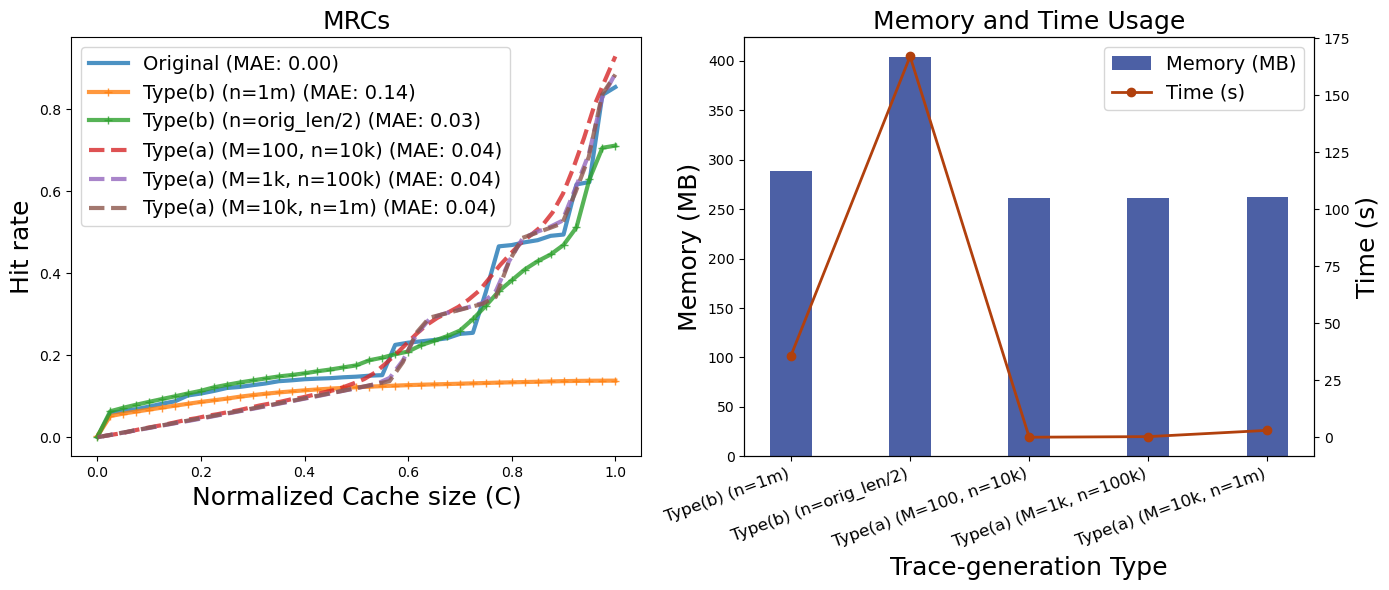

In [6]:
w44_gen_mem = [288.22, 403.70, 261.45, 261.51, 262.50]
w44_gen_time = [35.84, 167.05, 0.03, 0.29, 3.04]
c_44 = np.loadtxt(f'../data/performance/w44_c.txt', dtype=np.int32)
hr_44 = np.loadtxt(f'../data/performance/w44_hr.txt', dtype=np.float32)
c_tb_44 = np.loadtxt(f'../data/performance/w44_tb_c.txt', dtype=np.int32)
hr_tb_44 = np.loadtxt(f'../data/performance/w44_tb_hr.txt', dtype=np.float32)
c_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_c.txt', dtype=np.int32)
hr_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_hr.txt', dtype=np.float32)
c_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_c.txt', dtype=np.int32)
hr_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_hr.txt', dtype=np.float32)
c_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_c.txt', dtype=np.int32)
hr_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_hr.txt', dtype=np.float32)
c_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_c.txt', dtype=np.int32)
hr_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_hr.txt', dtype=np.float32)
plot_mrc_cost([c_44, c_tb_44, c_tbl_44, c_ta1_44, c_ta2_44, c_ta3_44],
            [hr_44, hr_tb_44, hr_tbl_44, hr_ta1_44, hr_ta2_44, hr_ta3_44],
            ['Original', 'Type(b) (n=1m)', 'Type(b) (n=orig_len/2)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'],
            location='best',
            gen_mem=w44_gen_mem, 
            gen_time=w44_gen_time)

In [9]:
w82 = load_trace_w('w82')
# tb_w82_1m = monitor(type_b_run2, w82, 1000000)
# np.savetxt(f'../data/performance/w82_tb_1m.txt', tb_w82_1m, fmt='%d')

In [36]:
tbl_w82 = monitor(type_b_run2, w82, len(w82)//2)
np.savetxt(f'../data/performance/w82_tb_len2.txt', tbl_w82, fmt='%d')

Process ID: 6587
Memory Usage: 472.19 MB
Elapsed Time: 52.84 seconds


In [38]:
f82 = tg.fgen(100, [12,13,19],1e-3)
ta1_w82 = monitor(type_a_run, 100, 10000, f82, 0.2)
ta2_w82 = monitor(type_a_run, 1000, 100000, f82, 0.2)
ta3_w82 = monitor(type_a_run, 10000, 1000000, f82, 0.2)
np.savetxt(f'../data/performance/w82_ta_10k.txt', ta1_w82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_100k.txt', ta2_w82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_1m.txt', ta3_w82, fmt='%d')

Process ID: 6703


Memory Usage: 464.96 MB
Elapsed Time: 0.06 seconds
Process ID: 6729
Memory Usage: 465.00 MB
Elapsed Time: 0.61 seconds
Process ID: 6753
Memory Usage: 465.84 MB
Elapsed Time: 6.22 seconds


In [39]:
c_82, hr_82 = mrc(w82)
c_tb_82, hr_tb_82 = mrc(tb_w82_1m)
c_tbl_82, hr_tbl_82 = mrc(tbl_w82)
c_ta1_82, hr_ta1_82 = mrc(ta1_w82)
c_ta2_82, hr_ta2_82 = mrc(ta2_w82)
c_ta3_82, hr_ta3_82 = mrc(ta3_w82)
np.savetxt(f'../data/performance/w82_hr.txt', hr_82, fmt='%f')
np.savetxt(f'../data/performance/w82_tb_1m_hr.txt', hr_tb_82, fmt='%f')
np.savetxt(f'../data/performance/w82_tb_len2_hr.txt', hr_tbl_82, fmt='%f')
np.savetxt(f'../data/performance/w82_ta_10k_hr.txt', hr_ta1_82, fmt='%f')
np.savetxt(f'../data/performance/w82_ta_100k_hr.txt', hr_ta2_82, fmt='%f')
np.savetxt(f'../data/performance/w82_ta_1m_hr.txt', hr_ta3_82, fmt='%f')
np.savetxt(f'../data/performance/w82_c.txt', c_82, fmt='%d')
np.savetxt(f'../data/performance/w82_tb_1m_c.txt', c_tb_82, fmt='%d')
np.savetxt(f'../data/performance/w82_tb_len2_c.txt', c_tbl_82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_10k_c.txt', c_ta1_82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_100k_c.txt', c_ta2_82, fmt='%d')
np.savetxt(f'../data/performance/w82_ta_1m_c.txt', c_ta3_82, fmt='%d')



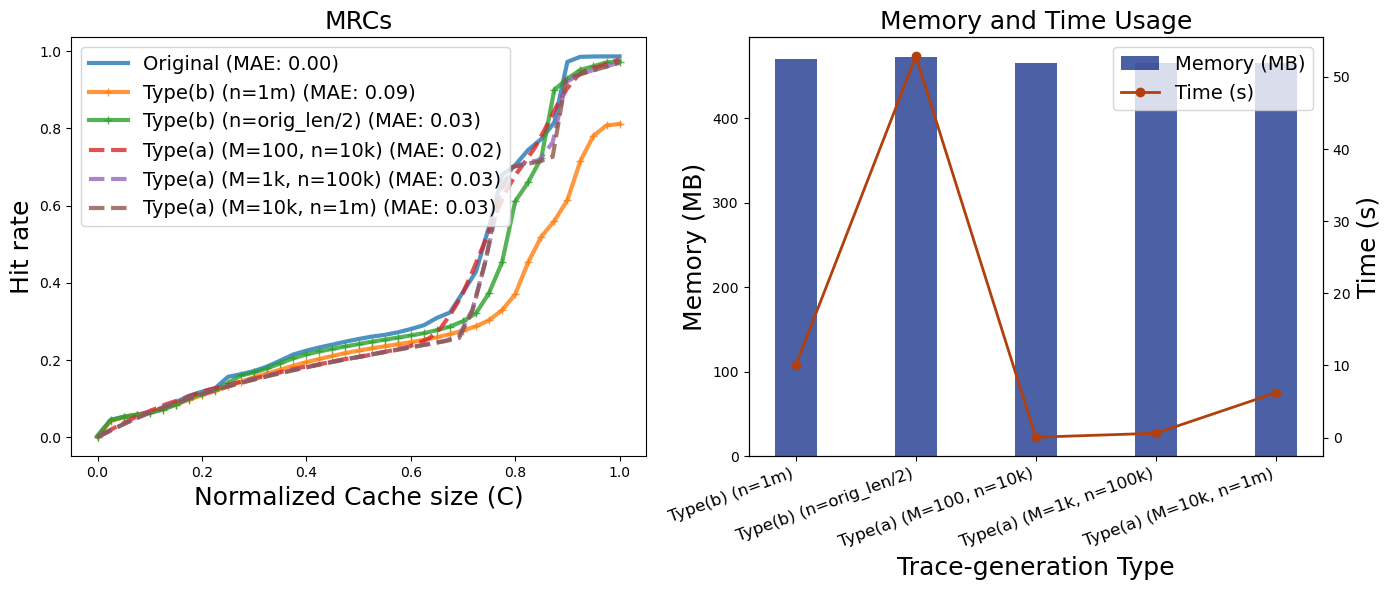

In [7]:
w82_gen_mem = [470.17,472.19,464.9,465.00,465.84]
w82_gen_time = [10.03,52.84,0.06,0.61,6.22]
c_82 = np.loadtxt(f'../data/performance/w82_c.txt', dtype=np.int32)
hr_82 = np.loadtxt(f'../data/performance/w82_hr.txt', dtype=np.float32)
c_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_c.txt', dtype=np.int32)
hr_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_hr.txt', dtype=np.float32)
c_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_c.txt', dtype=np.int32)
hr_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_hr.txt', dtype=np.float32)
c_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_c.txt', dtype=np.int32)
hr_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_hr.txt', dtype=np.float32)
c_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_c.txt', dtype=np.int32)
hr_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_hr.txt', dtype=np.float32)
c_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_c.txt', dtype=np.int32)
hr_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_hr.txt', dtype=np.float32)

plot_mrc_cost([c_82, c_tb_82, c_tbl_82, c_ta1_82, c_ta2_82, c_ta3_82],
            [hr_82, hr_tb_82, hr_tbl_82, hr_ta1_82, hr_ta2_82, hr_ta3_82],
            ['Original', 'Type(b) (n=1m)', 'Type(b) (n=orig_len/2)', 'Type(a) (M=100, n=10k)', 'Type(a) (M=1k, n=100k)', 'Type(a) (M=10k, n=1m)'],
            location='best',
            gen_mem=w82_gen_mem, 
            gen_time=w82_gen_time)

In [10]:
len(w82)

14198758

#### Type (b) does not scale well
- Need long enough trace to capture "full-resolution" of the MRC;
- Long enough trace is expensive to generate;
- Not long enough trace costs more than type (a) for the same length, but low accuracy.
#### Type (b) spends more time overall
-  Evidently even for generating the same length 1m with Type (a), but significantly lower accuracy.
#### Type (a) gen scales well
- Use the same set of parameter $\theta$ that is customized for M=100, n=10k, scales well;
- Could further increase accuracy by adjusting parameter $\theta$ for different scale.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_mrc_time(cs, lrus, names, location='upper left', gen_time=None):
    cs_normalized = [c / c.max() for c in cs]
    palette_mrcs = sns.color_palette()  # Default palette for MRCs
    palette_time = sns.color_palette("dark")  # "dark" palette for Time usage
    
    # Create a figure with two subplots: one for the MRCs and one for the time usage
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plotting the MRCs
    ax = axs[0]
    errors = [0]  # The first one is the reference, so error is 0
    for i in range(1, len(lrus)):
        error = calculate_error(lrus[0], lrus[i])
        errors.append(error)
    
    for i in range(len(cs)):
        if i == 0:
            linestyle = '-'
            marker = ''
            linewidth = 3
        elif i == 1:
            linestyle = '-'
            marker = '+'
            linewidth = 3
        else:
            linestyle = '--'
            marker = ''
            linewidth = 3
        
        label = f"{names[i]} (MAE: {errors[i]:.2f})"
        ax.plot(cs_normalized[i], lrus[i], linestyle + marker, label=label, linewidth=linewidth, color=palette_mrcs[i], alpha=0.8)

    ax.set_xlabel('Normalized Cache size (C)', fontsize=24)
    ax.set_ylabel('Hit rate', fontsize=24)
    ax.legend(loc=location, fontsize=15)
    ax.set_title("MRCs", fontsize=24)
    
    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(True)
    ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
    
    # Plotting the runtime usage
    ax2 = axs[1]
    indices = np.arange(len(gen_time))  # Ensure this covers all gen_time
    markers = ['o', 's', 'D', 'v', 'p']
    colors = sns.color_palette("dark", len(gen_time))  # Ensure enough colors for each gen_time
    
    for i in range(len(gen_time)):
        ax2.plot(indices[i], gen_time[i], label=names[i+1], marker=markers[i % len(markers)], linestyle='', linewidth=2,
                 color=colors[i-1], markersize=18, alpha=0.5)

    ax2.set_xlabel('Trace-gen Type', fontsize=24)
    ax2.set_ylabel('Run Time (sec)', fontsize=24)
    ax2.set_title('CPU Usage', fontsize=24)
    ax2.set_xticks(indices)
    # ax2.set_xticklabels(names[1:], rotation=0, ha='right', fontsize=12)
    ax2.legend(loc='upper right', fontsize=18)

    plt.tight_layout()
    plt.show()


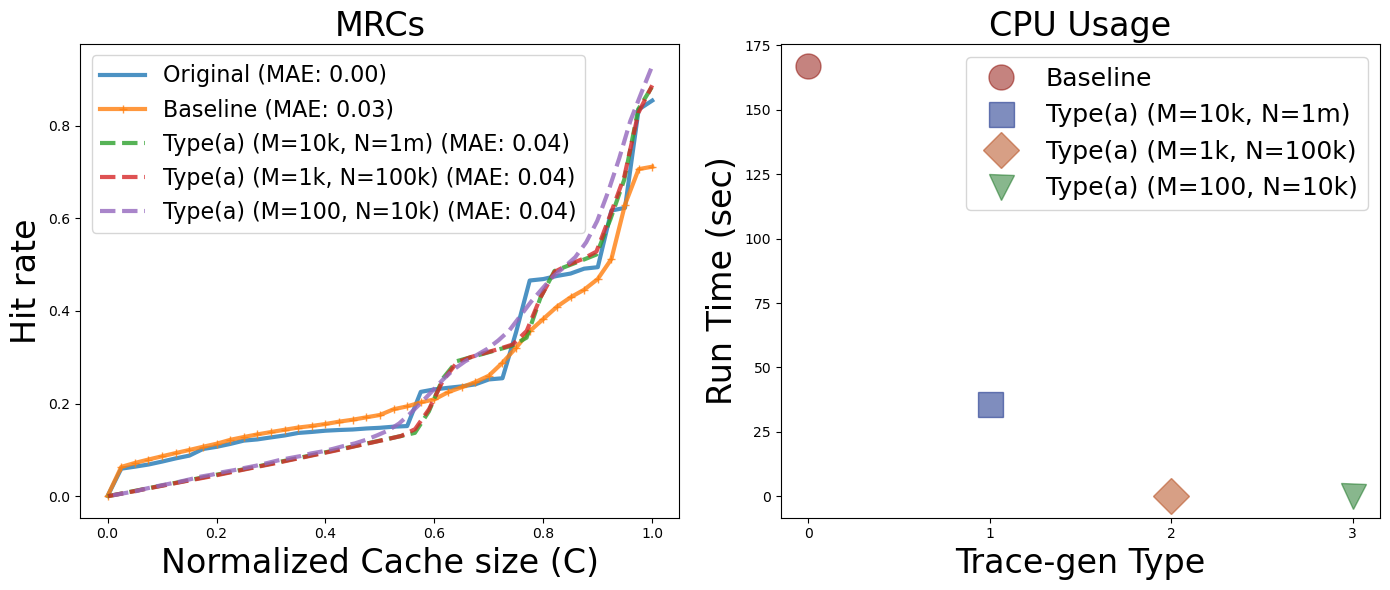

In [26]:

# w44_gen_time = [35.84, 167.05, 0.03, 0.29, 3.04]
w44_gen_time = [167.05, 35.84, 0.29, 0.03]
c_44 = np.loadtxt(f'../data/performance/w44_c.txt', dtype=np.int32)
hr_44 = np.loadtxt(f'../data/performance/w44_hr.txt', dtype=np.float32)
# c_tb_44 = np.loadtxt(f'../data/performance/w44_tb_c.txt', dtype=np.int32)
# hr_tb_44 = np.loadtxt(f'../data/performance/w44_tb_hr.txt', dtype=np.float32)
c_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_c.txt', dtype=np.int32)
hr_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_hr.txt', dtype=np.float32)
c_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_c.txt', dtype=np.int32)
hr_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_hr.txt', dtype=np.float32)
c_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_c.txt', dtype=np.int32)
hr_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_hr.txt', dtype=np.float32)
c_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_c.txt', dtype=np.int32)
hr_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_hr.txt', dtype=np.float32)
plot_mrc_time([c_44, c_tbl_44, c_ta3_44, c_ta2_44, c_ta1_44], [hr_44, hr_tbl_44, hr_ta3_44, hr_ta2_44, hr_ta1_44], ['Original', 'Baseline', 'Type(a) (M=10k, N=1m)', 'Type(a) (M=1k, N=100k)', 'Type(a) (M=100, N=10k)'], gen_time=w44_gen_time)

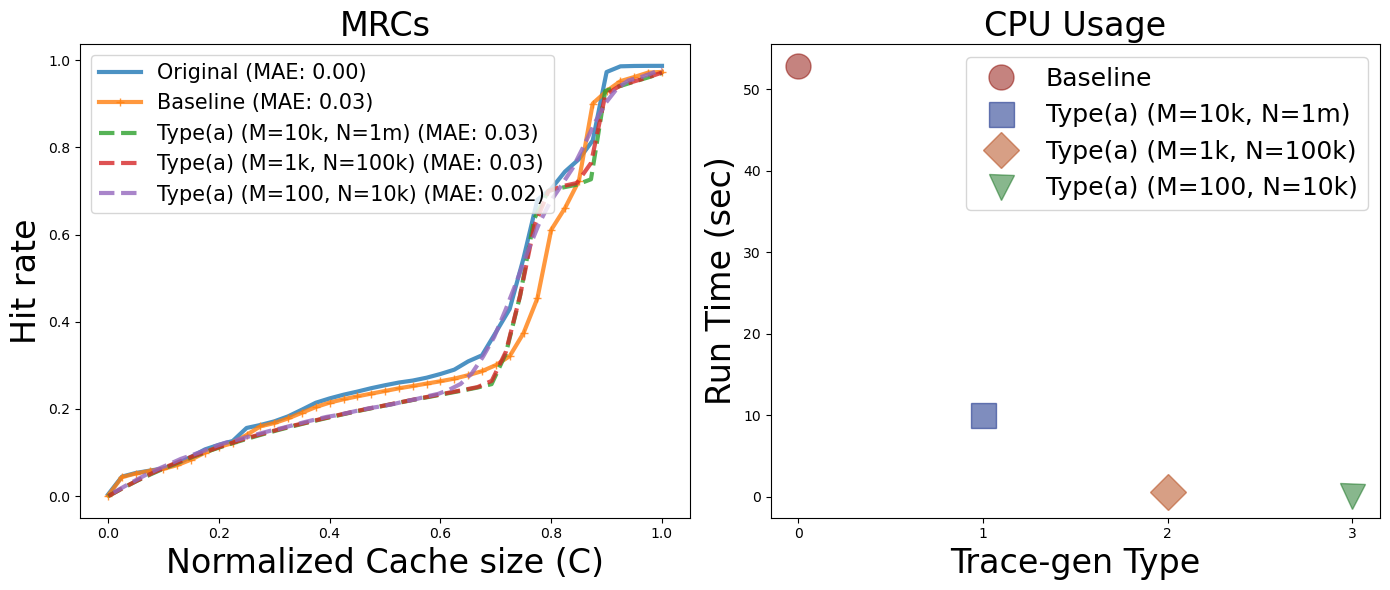

In [28]:
# w82_gen_time = [52.84, 10.03, 6.22, 0.61, 0.06]
w82_gen_time = [52.84, 10.03,0.61, 0.06]
c_82 = np.loadtxt(f'../data/performance/w82_c.txt', dtype=np.int32)
hr_82 = np.loadtxt(f'../data/performance/w82_hr.txt', dtype=np.float32)
# c_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_c.txt', dtype=np.int32)
# hr_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_hr.txt', dtype=np.float32)
c_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_c.txt', dtype=np.int32)
hr_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_hr.txt', dtype=np.float32)
c_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_c.txt', dtype=np.int32)
hr_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_hr.txt', dtype=np.float32)
c_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_c.txt', dtype=np.int32)
hr_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_hr.txt', dtype=np.float32)
c_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_c.txt', dtype=np.int32)
hr_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_hr.txt', dtype=np.float32)
plot_mrc_time([c_82, c_tbl_82, c_ta3_82, c_ta2_82, c_ta1_82], [hr_82, hr_tbl_82, hr_ta3_82, hr_ta2_82, hr_ta1_82], ['Original', 'Baseline', 'Type(a) (M=10k, N=1m)', 'Type(a) (M=1k, N=100k)', 'Type(a) (M=100, N=10k)'], gen_time=w82_gen_time)

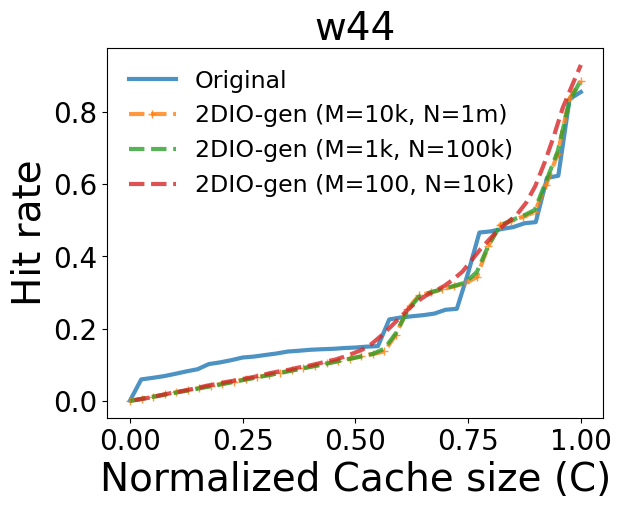

[0, 0.04346009829696525, 0.04327412411344638, 0.04477385219937309]


In [16]:
c_44 = np.loadtxt(f'../data/performance/w44_c.txt', dtype=np.int32)
hr_44 = np.loadtxt(f'../data/performance/w44_hr.txt', dtype=np.float32)
# c_tb_44 = np.loadtxt(f'../data/performance/w44_tb_c.txt', dtype=np.int32)
# hr_tb_44 = np.loadtxt(f'../data/performance/w44_tb_hr.txt', dtype=np.float32)
# c_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_c.txt', dtype=np.int32)
# hr_tbl_44 = np.loadtxt(f'../data/performance/w44_tb_len2_hr.txt', dtype=np.float32)
c_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_c.txt', dtype=np.int32)
hr_ta1_44 = np.loadtxt(f'../data/performance/w44_ta_10k_hr.txt', dtype=np.float32)
c_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_c.txt', dtype=np.int32)
hr_ta2_44 = np.loadtxt(f'../data/performance/w44_ta_100k_hr.txt', dtype=np.float32)
c_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_c.txt', dtype=np.int32)
hr_ta3_44 = np.loadtxt(f'../data/performance/w44_ta_1m_hr.txt', dtype=np.float32)
plot_mrcs([c_44, c_ta3_44, c_ta2_44, c_ta1_44], [hr_44, hr_ta3_44, hr_ta2_44, hr_ta1_44], ['Original', '2DIO-gen (M=10k, N=1m)', '2DIO-gen (M=1k, N=100k)', '2DIO-gen (M=100, N=10k)'], 'w44', location='upper left')

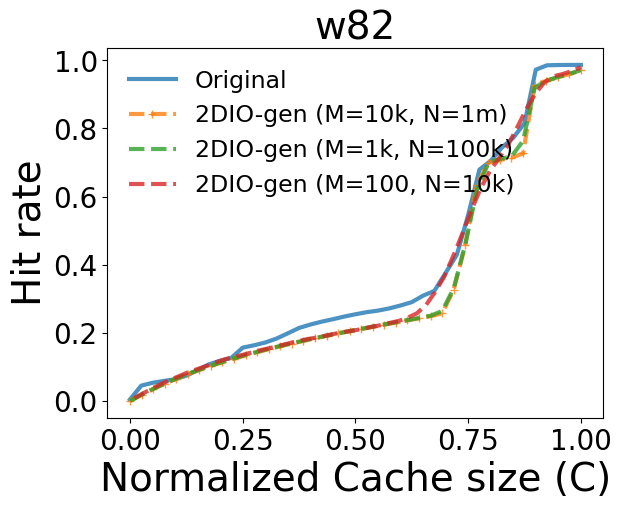

[0, 0.03437873018447576, 0.032887216718624615, 0.02399547950801799]


In [15]:
c_82 = np.loadtxt(f'../data/performance/w82_c.txt', dtype=np.int32)
hr_82 = np.loadtxt(f'../data/performance/w82_hr.txt', dtype=np.float32)
# c_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_c.txt', dtype=np.int32)
# hr_tb_82 = np.loadtxt(f'../data/performance/w82_tb_1m_hr.txt', dtype=np.float32)
# c_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_c.txt', dtype=np.int32)
# hr_tbl_82 = np.loadtxt(f'../data/performance/w82_tb_len2_hr.txt', dtype=np.float32)
c_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_c.txt', dtype=np.int32)
hr_ta1_82 = np.loadtxt(f'../data/performance/w82_ta_10k_hr.txt', dtype=np.float32)
c_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_c.txt', dtype=np.int32)
hr_ta2_82 = np.loadtxt(f'../data/performance/w82_ta_100k_hr.txt', dtype=np.float32)
c_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_c.txt', dtype=np.int32)
hr_ta3_82 = np.loadtxt(f'../data/performance/w82_ta_1m_hr.txt', dtype=np.float32)
plot_mrcs([c_82, c_ta3_82, c_ta2_82, c_ta1_82], [hr_82, hr_ta3_82, hr_ta2_82, hr_ta1_82], ['Original', '2DIO-gen (M=10k, N=1m)', '2DIO-gen (M=1k, N=100k)', '2DIO-gen (M=100, N=10k)'], 'w82', location='upper left')

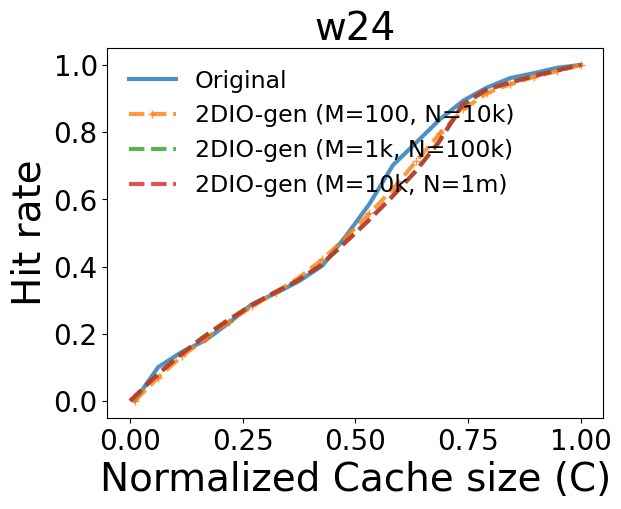

[0, 0.01865422871360875, 0.022417592018499168, 0.022474537807446113]


In [12]:
# w24
w24 = load_trace_w('w24')
f24 = tg.fgen(30, np.array([1,2]),5e-3)
g24 = tg.TraceGenerator(100, 10000)
t24_100_10k = g24.gen_from_pdf(f24, 0.45)
np.savetxt(f'traces/w24_100_10k.txt', t24_100_10k, fmt='%d')
c24_100_10k, hr24_100_10k = mrc(t24_100_10k)
np.savetxt(f'../data/performance/c24_100_10k.txt', c24_100_10k, fmt='%d')
np.savetxt(f'../data/performance/hr24_100_10k.txt', hr24_100_10k, fmt='%f')
g24 = tg.TraceGenerator(1000, 100000)
t24_1k_100k = g24.gen_from_pdf(f24, 0.45)
np.savetxt(f'traces/w24_1k_100k.txt', t24_1k_100k, fmt='%d')
c24_1k_100k, hr24_1k_100k = mrc(t24_1k_100k)
np.savetxt(f'../data/performance/c24_1k_100k.txt', c24_1k_100k, fmt='%d')
np.savetxt(f'../data/performance/hr24_1k_100k.txt', hr24_1k_100k, fmt='%f')
g24 = tg.TraceGenerator(10000, 1000000)
t24_10k_1m = g24.gen_from_pdf(f24, 0.45)
np.savetxt(f'traces/w24_10k_1m.txt', t24_10k_1m, fmt='%d')
c24_10k_1m, hr24_10k_1m = mrc(t24_10k_1m)
np.savetxt(f'../data/performance/c24_10k_1m.txt', c24_10k_1m, fmt='%d')
np.savetxt(f'../data/performance/hr24_10k_1m.txt', hr24_10k_1m, fmt='%f')

c24 = np.loadtxt('../data/LRU/w24_c.txt', dtype=np.int32)
hr24 = np.loadtxt('../data/LRU/w24_lru_hr.txt', dtype=np.float32)
plot_mrcs([c24, c24_100_10k, c24_1k_100k, c24_10k_1m], [norm(hr24), norm(hr24_100_10k), norm(hr24_1k_100k), norm(hr24_10k_1m)], ['Original', '2DIO-gen (M=100, N=10k)', '2DIO-gen (M=1k, N=100k)', '2DIO-gen (M=10k, N=1m)'], 'w24', location='upper left')

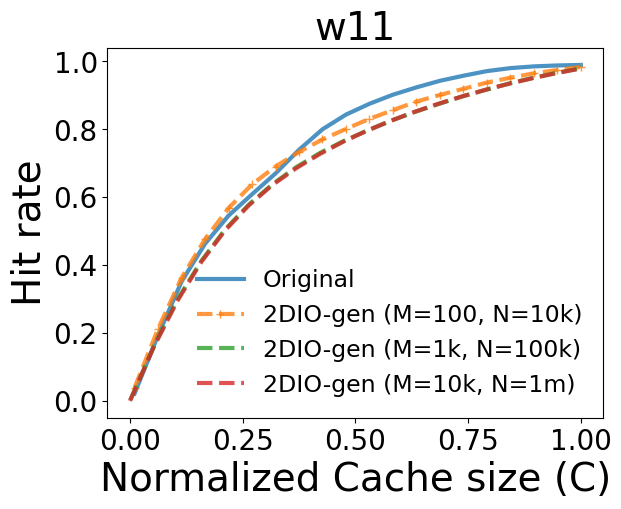

[0, 0.02620144822046161, 0.04862425236013531, 0.05046720236013532]


In [14]:
# w11
c11 = np.loadtxt('../data/LRU/w11_c.txt', dtype=np.int32)
hr11 = np.loadtxt('../data/LRU/w11_lru_hr.txt', dtype=np.float32)
g11 = tg.TraceGenerator(100, 10000)
g11.set_irm_type('zipf')
g11.set_zipf(1.3)
t11_100_10k = g11.gen_from_pdf(g11.pdf_b, 1.0)
np.savetxt(f'traces/w11_100_10k.txt', t11_100_10k, fmt='%d')
c11_100_10k, hr11_100_10k = mrc(t11_100_10k)
np.savetxt(f'../data/performance/c11_100_10k.txt', c11_100_10k, fmt='%d')
np.savetxt(f'../data/performance/hr11_100_10k.txt', hr11_100_10k, fmt='%f')
g11 = tg.TraceGenerator(1000, 100000)
t11_1k_100k = g11.gen_from_pdf(g11.pdf_b, 1.0)
np.savetxt(f'traces/w11_1k_100k.txt', t11_1k_100k, fmt='%d')
c11_1k_100k, hr11_1k_100k = mrc(t11_1k_100k)
np.savetxt(f'../data/performance/c11_1k_100k.txt', c11_1k_100k, fmt='%d')
np.savetxt(f'../data/performance/hr11_1k_100k.txt', hr11_1k_100k, fmt='%f')
g11 = tg.TraceGenerator(10000, 1000000)
t11_10k_1m = g11.gen_from_pdf(g11.pdf_b, 1.0)
np.savetxt(f'traces/w11_10k_1m.txt', t11_10k_1m, fmt='%d')
c11_10k_1m, hr11_10k_1m = mrc(t11_10k_1m)
np.savetxt(f'../data/performance/c11_10k_1m.txt', c11_10k_1m, fmt='%d')
np.savetxt(f'../data/performance/hr11_10k_1m.txt', hr11_10k_1m, fmt='%f')

plot_mrcs([c11, c11_100_10k, c11_1k_100k, c11_10k_1m], [hr11, hr11_100_10k, hr11_1k_100k, hr11_10k_1m], ['Original', '2DIO-gen (M=100, N=10k)', '2DIO-gen (M=1k, N=100k)', '2DIO-gen (M=10k, N=1m)'], 'w11', location='lower right')

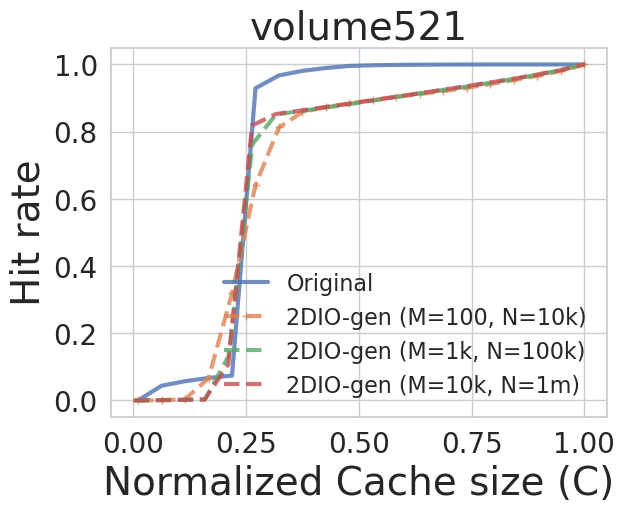

[0, 0.08638829181192469, 0.07161060219269579, 0.06704694810316661]


In [48]:
# v521
# c521 = np.loadtxt('../data/LRU/v521_c.txt', dtype=np.int32)
# hr521 = np.loadtxt('../data/LRU/v521_lru_hr.txt', dtype=np.float32)
# g521 = tg.TraceGenerator(100, 10000)
# pdf521 = tg.fgen(100, np.array([2]), 2e-3)
# t521_100_10k = g521.gen_from_pdf(pdf521, 0.0)
# np.savetxt(f'traces/v521_100_10k.txt', t521_100_10k, fmt='%d')
# c521_100_10k, hr521_100_10k = mrc(t521_100_10k)
# np.savetxt(f'../data/performance/c521_100_10k.txt', c521_100_10k, fmt='%d')
# np.savetxt(f'../data/performance/hr521_100_10k.txt', hr521_100_10k, fmt='%f')
# g521 = tg.TraceGenerator(1000, 100000)
# t521_1k_100k = g521.gen_from_pdf(pdf521, 0.0)
# np.savetxt(f'traces/v521_1k_100k.txt', t521_1k_100k, fmt='%d')
# c521_1k_100k, hr521_1k_100k = mrc(t521_1k_100k)
# np.savetxt(f'../data/performance/c521_1k_100k.txt', c521_1k_100k, fmt='%d')
# np.savetxt(f'../data/performance/hr521_1k_100k.txt', hr521_1k_100k, fmt='%f')
# g521 = tg.TraceGenerator(10000, 1000000)
# t521_10k_1m = g521.gen_from_pdf(pdf521, 0.0)
# np.savetxt(f'traces/v521_10k_1m.txt', t521_10k_1m, fmt='%d')
# c521_10k_1m, hr521_10k_1m = mrc(t521_10k_1m)
# np.savetxt(f'../data/performance/c521_10k_1m.txt', c521_10k_1m, fmt='%d')
# np.savetxt(f'../data/performance/hr521_10k_1m.txt', hr521_10k_1m, fmt='%f')

plot_mrcs([c521, c521_100_10k, c521_1k_100k, c521_10k_1m], [norm(hr521), norm(hr521_100_10k), norm(hr521_1k_100k), norm(hr521_10k_1m)], ['Original', '2DIO-gen (M=100, N=10k)', '2DIO-gen (M=1k, N=100k)', '2DIO-gen (M=10k, N=1m)'], 'volume521', location='lower right')


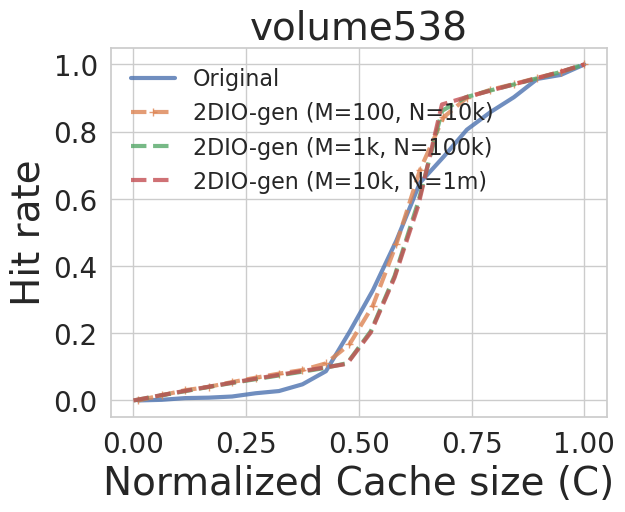

[0, 0.03687197026985144, 0.047486187750489066, 0.05012135089912937]


In [49]:
# v538
# c538 = np.loadtxt('../data/LRU/v538_c.txt', dtype=np.int32)
# hr538 = np.loadtxt('../data/LRU/v538_lru_hr.txt', dtype=np.float32)
# g538 = tg.TraceGenerator(100, 10000)
# pdf538 = tg.fgen(40,np.array([3,4]), 5e-3)
# t538_100_10k = g538.gen_from_pdf(pdf538, 0.1)
# np.savetxt(f'traces/v538_100_10k.txt', t538_100_10k, fmt='%d')
# c538_100_10k, hr538_100_10k = mrc(t538_100_10k)
# np.savetxt(f'../data/performance/c538_100_10k.txt', c538_100_10k, fmt='%d')
# np.savetxt(f'../data/performance/hr538_100_10k.txt', hr538_100_10k, fmt='%f')
# g538 = tg.TraceGenerator(1000, 100000)
# t538_1k_100k = g538.gen_from_pdf(pdf538, 0.1)
# np.savetxt(f'traces/v538_1k_100k.txt', t538_1k_100k, fmt='%d')
# c538_1k_100k, hr538_1k_100k = mrc(t538_1k_100k)
# np.savetxt(f'../data/performance/c538_1k_100k.txt', c538_1k_100k, fmt='%d')
# np.savetxt(f'../data/performance/hr538_1k_100k.txt', hr538_1k_100k, fmt='%f')
# g538 = tg.TraceGenerator(10000, 1000000)
# t538_10k_1m = g538.gen_from_pdf(pdf538, 0.1)
# np.savetxt(f'traces/v538_10k_1m.txt', t538_10k_1m, fmt='%d')
# c538_10k_1m, hr538_10k_1m = mrc(t538_10k_1m)
# np.savetxt(f'../data/performance/c538_10k_1m.txt', c538_10k_1m, fmt='%d')
# np.savetxt(f'../data/performance/hr538_10k_1m.txt', hr538_10k_1m, fmt='%f')

plot_mrcs([c538, c538_100_10k, c538_1k_100k, c538_10k_1m], [norm(hr538), norm(hr538_100_10k), norm(hr538_1k_100k), norm(hr538_10k_1m)], ['Original', '2DIO-gen (M=100, N=10k)', '2DIO-gen (M=1k, N=100k)', '2DIO-gen (M=10k, N=1m)'], 'volume538', location='upper left')

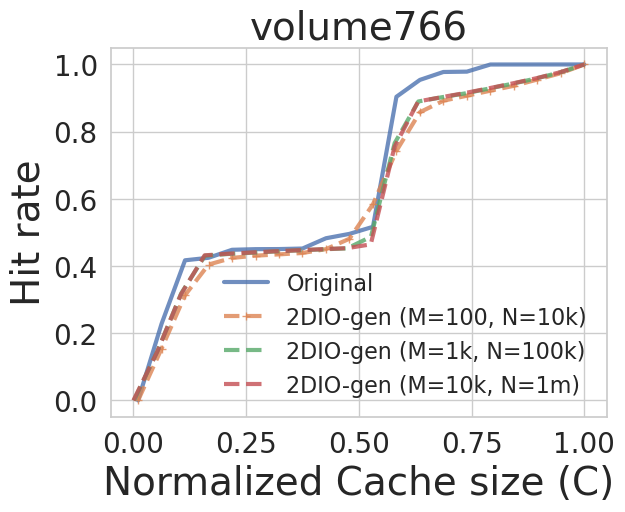

[0, 0.0505315697029202, 0.04299292542406311, 0.04473159947308309]


In [50]:
# v766
c766 = np.loadtxt('../data/LRU/v766_c.txt', dtype=np.int32)
hr766 = np.loadtxt('../data/LRU/v766_lru_hr.txt', dtype=np.float32)
g766 = tg.TraceGenerator(100, 10000)
pdf766 = tg.fgen(40, [0,5], 5.7e-3)
t766_100_10k = g766.gen_from_pdf(pdf766, 0.0)
np.savetxt(f'traces/v766_100_10k.txt', t766_100_10k, fmt='%d')
c766_100_10k, hr766_100_10k = mrc(t766_100_10k)
np.savetxt(f'../data/performance/c766_100_10k.txt', c766_100_10k, fmt='%d')
np.savetxt(f'../data/performance/hr766_100_10k.txt', hr766_100_10k, fmt='%f')
g766 = tg.TraceGenerator(1000, 100000)
t766_1k_100k = g766.gen_from_pdf(pdf766, 0.0)
np.savetxt(f'traces/v766_1k_100k.txt', t766_1k_100k, fmt='%d')
c766_1k_100k, hr766_1k_100k = mrc(t766_1k_100k)
np.savetxt(f'../data/performance/c766_1k_100k.txt', c766_1k_100k, fmt='%d')
np.savetxt(f'../data/performance/hr766_1k_100k.txt', hr766_1k_100k, fmt='%f')
g766 = tg.TraceGenerator(10000, 1000000)
t766_1k_100k = g766.gen_from_pdf(pdf766, 0.0)
np.savetxt(f'traces/v766_10k_1m.txt', t766_1k_100k, fmt='%d')
c766_10k_1m, hr766_10k_1m = mrc(t766_1k_100k)
np.savetxt(f'../data/performance/c766_10k_1m.txt', c766_10k_1m, fmt='%d')
np.savetxt(f'../data/performance/hr766_10k_1m.txt', hr766_10k_1m, fmt='%f')

plot_mrcs([c766, c766_100_10k, c766_1k_100k, c766_10k_1m], [norm(hr766), norm(hr766_100_10k), norm(hr766_1k_100k), norm(hr766_10k_1m)], ['Original', '2DIO-gen (M=100, N=10k)', '2DIO-gen (M=1k, N=100k)', '2DIO-gen (M=10k, N=1m)'], 'volume766', location='lower right')

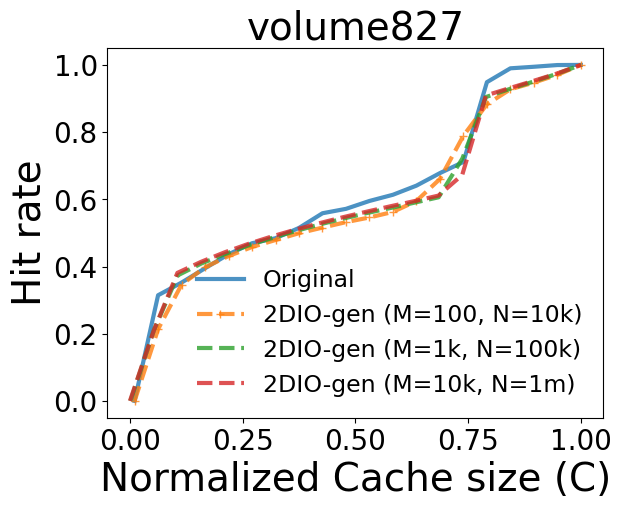

[0, 0.033788083278084684, 0.029987983729765466, 0.030422750701558497]


In [22]:
# v827
c827 = np.loadtxt('../data/LRU/v827_c.txt', dtype=np.int32)
hr827 = np.loadtxt('../data/LRU/v827_lru_hr.txt', dtype=np.float32)
g827 = tg.TraceGenerator(100, 10000)
pdf827 = tg.fgen(60, np.array([0,13]), 5e-3)
t827_100_10k = g827.gen_from_pdf(pdf827, 0.2)
np.savetxt(f'traces/v827_100_10k.txt', t827_100_10k, fmt='%d')
c827_100_10k, hr827_100_10k = mrc(t827_100_10k)
np.savetxt(f'../data/performance/c827_100_10k.txt', c827_100_10k, fmt='%d')
np.savetxt(f'../data/performance/hr827_100_10k.txt', hr827_100_10k, fmt='%f')
g827 = tg.TraceGenerator(1000, 100000)
t827_1k_100k = g827.gen_from_pdf(pdf827, 0.2)
np.savetxt(f'traces/v827_1k_100k.txt', t827_1k_100k, fmt='%d')
c827_1k_100k, hr827_1k_100k = mrc(t827_1k_100k)
np.savetxt(f'../data/performance/c827_1k_100k.txt', c827_1k_100k, fmt='%d')
np.savetxt(f'../data/performance/hr827_1k_100k.txt', hr827_1k_100k, fmt='%f')
g827 = tg.TraceGenerator(10000, 1000000)
t827_10k_1m = g827.gen_from_pdf(pdf827, 0.2)
np.savetxt(f'traces/v827_10k_1m.txt', t827_10k_1m, fmt='%d')
c827_10k_1m, hr827_10k_1m = mrc(t827_10k_1m)
np.savetxt(f'../data/performance/c827_10k_1m.txt', c827_10k_1m, fmt='%d')
np.savetxt(f'../data/performance/hr827_10k_1m.txt', hr827_10k_1m, fmt='%f')

plot_mrcs([c827, c827_100_10k, c827_1k_100k, c827_10k_1m], [norm(hr827), norm(hr827_100_10k), norm(hr827_1k_100k), norm(hr827_10k_1m)], ['Original', '2DIO-gen (M=100, N=10k)', '2DIO-gen (M=1k, N=100k)', '2DIO-gen (M=10k, N=1m)'], 'volume827', location='lower right')

In [ ]:
mae_11 = [0, 0.02620144822046161, 0.04862425236013531, 0.05046720236013532]
mae_24 = [0, 0.01865422871360875, 0.022417592018499168, 0.022474537807446113]
mae_44 = [0, 0.04346009829696525, 0.04327412411344638, 0.04477385219937309]
mae_82 = [0, 0.03437873018447576, 0.032887216718624615, 0.02399547950801799]
mae_521 = [0, 0.08638829181192469, 0.07161060219269579, 0.06704694810316661]
mae_538 = [0, 0.03687197026985144, 0.047486187750489066, 0.05012135089912937]
mae_766 = [0, 0.05133605379001192, 0.04238100870857323, 0.04476547303602382]
mae_827 = [0, 0.033788083278084684, 0.029987983729765466, 0.030422750701558497]

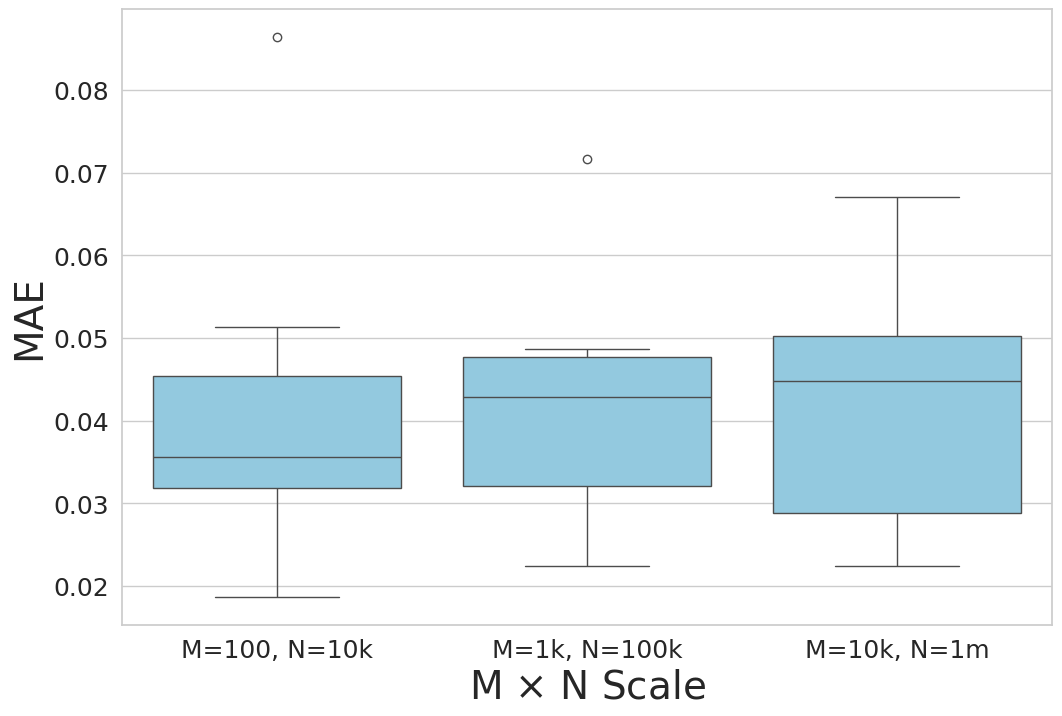

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Data preparation
data = {
    "Baseline": [0, 0, 0, 0, 0, 0, 0, 0],
    "M=100, N=10k": [
        0.02620144822046161, 0.01865422871360875, 0.04346009829696525, 
        0.03437873018447576, 0.08638829181192469, 0.03687197026985144, 
        0.05133605379001192, 0.033788083278084684
    ],
    "M=1k, N=100k": [
        0.04862425236013531, 0.022417592018499168, 0.04327412411344638, 
        0.032887216718624615, 0.07161060219269579, 0.047486187750489066, 
        0.04238100870857323, 0.029987983729765466
    ],
    "M=10k, N=1m": [
        0.05046720236013532, 0.022474537807446113, 0.04477385219937309, 
        0.02399547950801799, 0.06704694810316661, 0.05012135089912937, 
        0.04476547303602382, 0.030422750701558497
    ],
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop(columns=["Baseline"]), color="skyblue")
# plt.title("Across M & N Scales", fontsize=28)
plt.ylabel("MAE", fontsize=28)
plt.xlabel(r"M $\times$ N Scale", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


In [66]:
# fix M 1000, vary N from 10k to 1m
# {}w
def fix_m_vary_n(w, m, ns, pdf, pirm):
    if m == 1000:
        m_str = '1k'
    n_strs = []
    cs, hrs = [], []
    c_orig = np.loadtxt(f'../data/LRU/{w}_c.txt', dtype=np.int32)
    hr_orig = np.loadtxt(f'../data/LRU/{w}_lru_hr.txt', dtype=np.float32)
    cs.append(c_orig)
    hrs.append(hr_orig)
    for i, n in enumerate(ns):
        if n == 10000:
            n_strs.append('10k')
        if n == 50000:
            n_strs.append('50k')
        if n == 100000:
            n_strs.append('100k')
        if n == 500000:
            n_strs.append('500k')
        if n == 1000000:
            n_strs.append('1m')
    
        g = tg.TraceGenerator(m, n)
        t = g.gen_from_pdf(pdf, pirm)
        np.savetxt(f'traces/{w}_{m}_{n_strs[i]}.txt', t, fmt='%d')
        c_, hr_ = mrc(t)
        cs.append(c_)
        hrs.append(hr_)
        np.savetxt(f'../data/performance/{w}_{m}_{n_strs[i]}_c.txt', c_, fmt='%d')
        np.savetxt(f'../data/performance/{w}_{m}_{n_strs[i]}_hr.txt', hr_, fmt='%f')
    
    plot_mrcs([cs[i] for i in range(len(cs))], [norm(hrs[i]) for i in range(len(hrs))], [f'Original'] + [f'2DIO-gen (M={m_str}, N={n_str})' for n_str in n_strs], w, location='best')

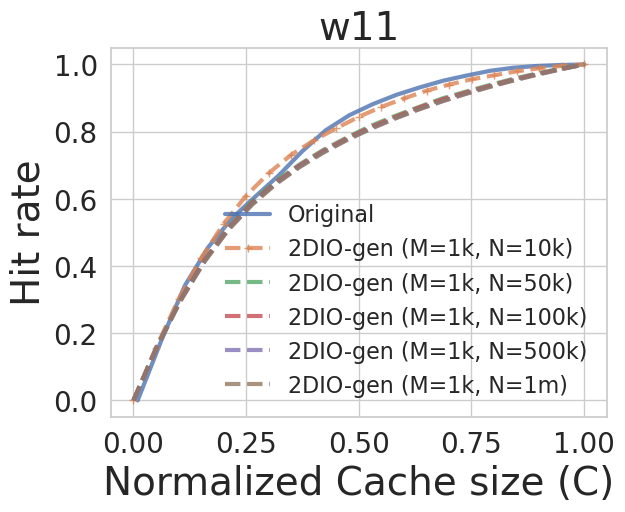

[0, 0.013364684762541242, 0.035417345299599695, 0.03759667098012841, 0.040610387909165005, 0.04134255662288446]


In [87]:
f11 = tg.fgen(20, np.array([0,3]),5e-3)
fix_m_vary_n('w11', 1000, [10000, 50000, 100000, 500000, 1000000], f11, 1.0)

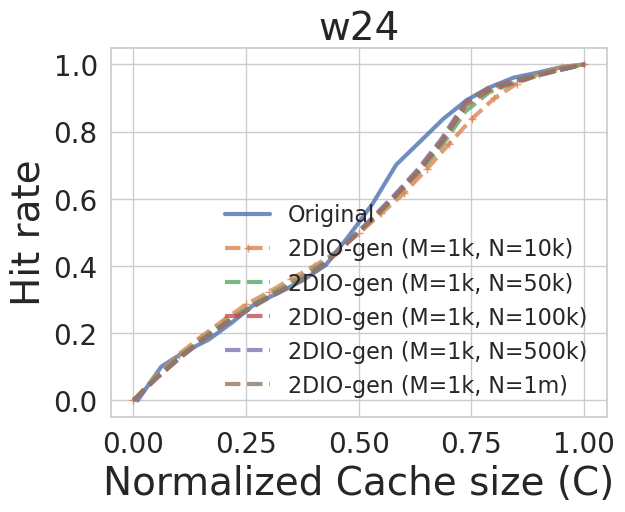

[0, 0.03289735610603273, 0.025435436558430093, 0.022565706332687323, 0.01974090581164279, 0.020925555048579896]


In [62]:
fix_m_vary_n('w24', 1000, [10000, 50000, 100000, 500000, 1000000], f24, 0.45)

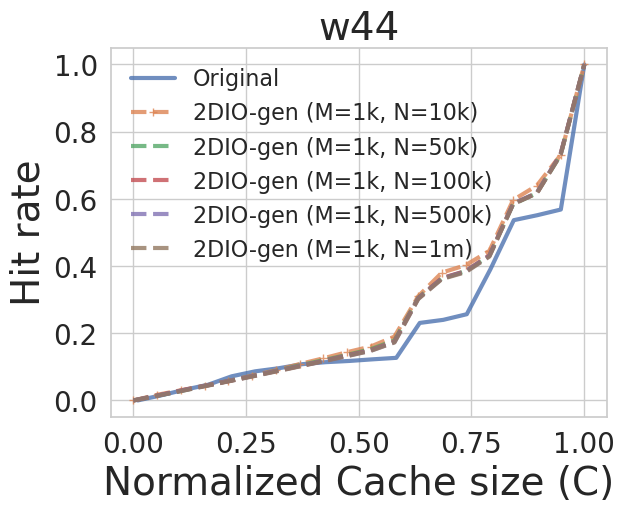

[0, 0.0455256938098059, 0.039793347937816, 0.03971083064987861, 0.03923053941340586, 0.03887751348608727]


In [67]:
f44 = tg.fgen(30, np.array([9, 13, 17, 19]), 2.5e-2)
fix_m_vary_n('w44', 1000, [10000, 50000, 100000, 500000, 1000000], f44, 0.0)

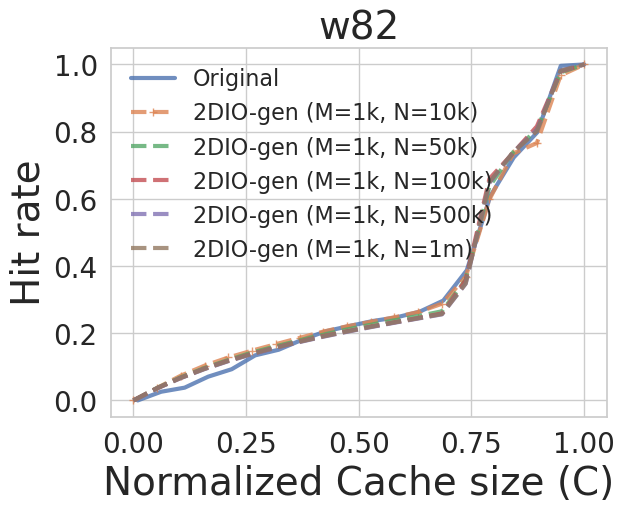

[0, 0.01344203797590134, 0.015052472129743666, 0.017618175996752746, 0.01729629782611844, 0.017124248822413056]


In [68]:
f82 = tg.fgen(100, np.array([12, 13, 19]), 1e-3)
fix_m_vary_n('w82', 1000, [10000, 50000, 100000, 500000, 1000000], f82, 0.2)

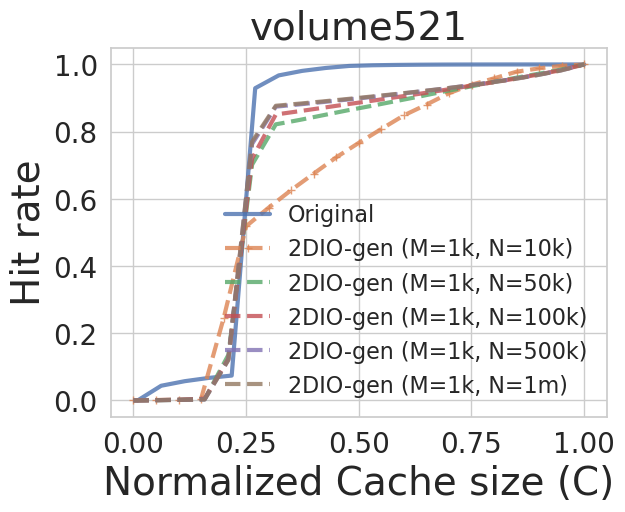

[0, 0.13087423016083016, 0.08147842085206182, 0.07331118420040525, 0.06577610599356179, 0.06492334052638274]


In [72]:
fix_m_vary_n('v521', 1000, [10000, 50000, 100000, 500000, 1000000], pdf521, 0.0) 

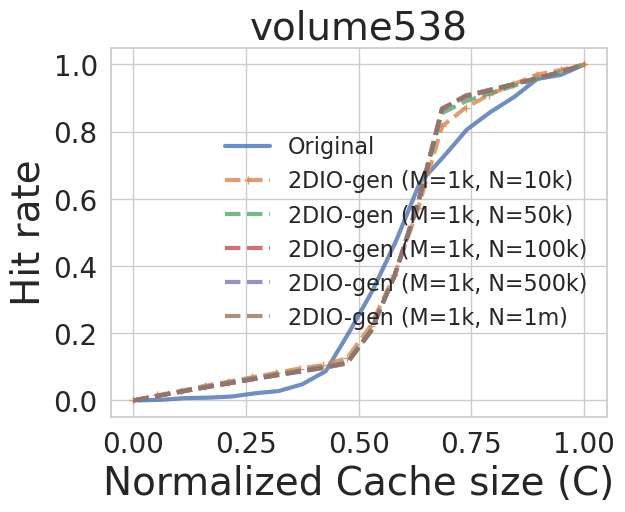

[0, 0.04587675967686611, 0.04732864757036687, 0.048391869377934625, 0.048631028486450276, 0.04866436995410424]


In [73]:
pdf538 = tg.fgen(40,np.array([3,4]), 5e-3)
fix_m_vary_n('v538', 1000, [10000, 50000, 100000, 500000, 1000000], pdf538, 0.1)

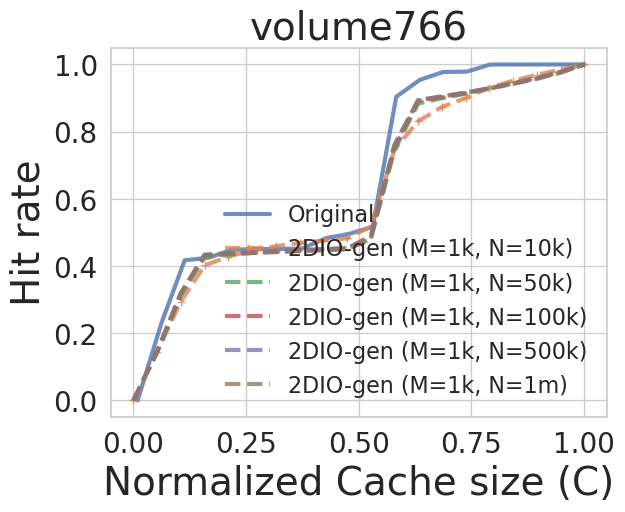

[0, 0.046197212892542576, 0.04511845208067781, 0.043472879231368916, 0.04339939336399417, 0.04402700492671342]


In [74]:
f766 = tg.fgen(40, [0,5], 5.7e-3)
fix_m_vary_n('v766', 1000, [10000, 50000, 100000, 500000, 1000000], f766, 0.0)

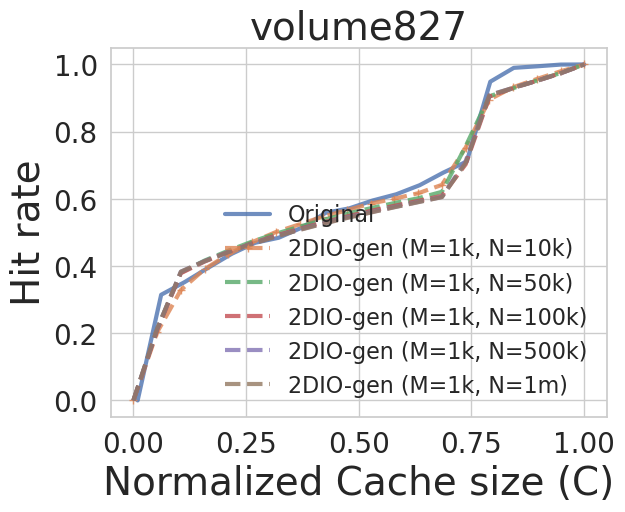

[0, 0.023894627651813365, 0.02883369694495272, 0.029171231286697918, 0.02976523754817858, 0.03020383160834956]


In [75]:
f827 = tg.fgen(60, np.array([0,13]), 5e-3)
fix_m_vary_n('v827', 1000, [10000, 50000, 100000, 500000, 1000000], f827, 0.2)

In [ ]:
mae_w11_fix_m = [0, 0.08866475236013531, 0.052782752360135334, 0.04807275236013532, 0.047247952360135306, 0.04721815236013531]
mae_w24_fix_m = [0, 0.03289735610603273, 0.025435436558430093, 0.022565706332687323, 0.01974090581164279, 0.020925555048579896]
mae_w44_fix_m = [0, 0.0455256938098059, 0.039793347937816, 0.03971083064987861, 0.03923053941340586, 0.03887751348608727]
mae_w82_fix_m = [0, 0.01344203797590134, 0.015052472129743666, 0.017618175996752746, 0.01729629782611844, 0.017124248822413056]
mae_v521_fix_m = [0, 0.13087423016083016, 0.08147842085206182, 0.07331118420040525, 0.06577610599356179, 0.06492334052638274]
mae_v538_fix_m = [0, 0.04587675967686611, 0.04732864757036687, 0.048391869377934625, 0.048631028486450276, 0.04866436995410424]
mae_v766_fix_m = [0, 0.046197212892542576, 0.04511845208067781, 0.043472879231368916, 0.04339939336399417, 0.04402700492671342]
mae_v827_fix_m = [0, 0.023894627651813365, 0.02883369694495272, 0.029171231286697918, 0.02976523754817858, 0.03020383160834956]

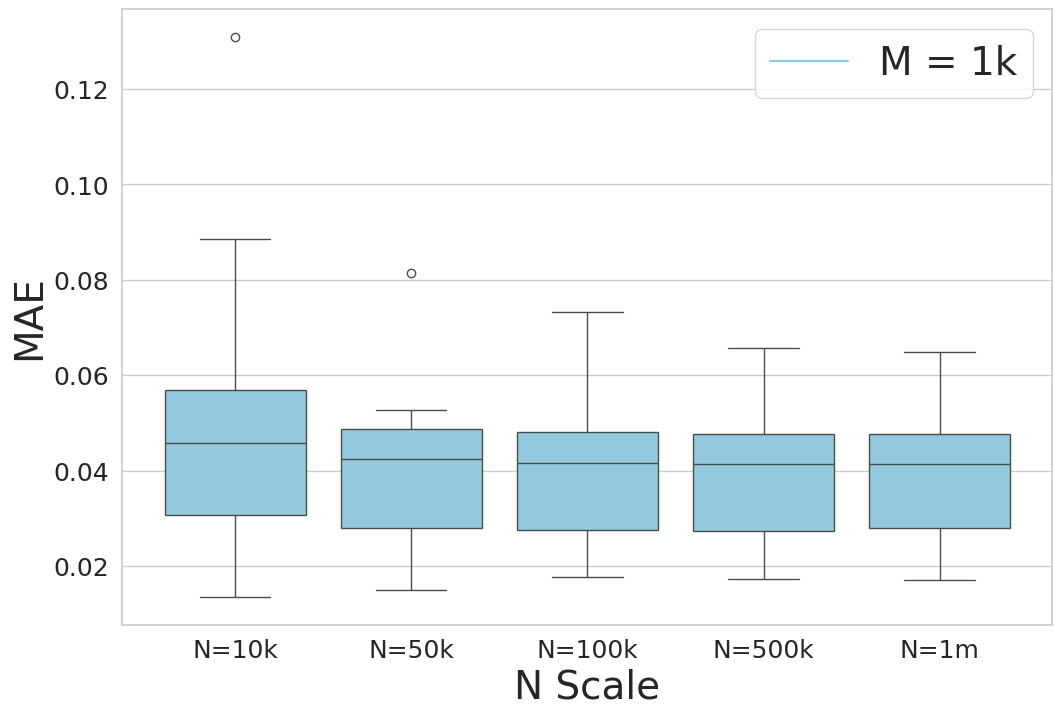

In [83]:
data_fix_m = {
    "Baseline": [0, 0, 0, 0, 0, 0, 0, 0],
    "N=10k": [
        0.08866475236013531, 0.03289735610603273, 0.0455256938098059, 
        0.01344203797590134, 0.13087423016083016, 0.04587675967686611, 
        0.046197212892542576, 0.023894627651813365
    ],
    "N=50k": [
        0.052782752360135334, 0.025435436558430093, 0.039793347937816, 
        0.015052472129743666, 0.08147842085206182, 0.04732864757036687, 
        0.04511845208067781, 0.02883369694495272
    ],
    "N=100k": [
        0.04807275236013532, 0.022565706332687323, 0.03971083064987861, 
        0.017618175996752746, 0.07331118420040525, 0.048391869377934625, 
        0.043472879231368916, 0.029171231286697918
    ],
    "N=500k": [
        0.047247952360135306, 0.01974090581164279, 0.03923053941340586, 
        0.01729629782611844, 0.06577610599356179, 0.048631028486450276, 
        0.04339939336399417, 0.02976523754817858
    ],
    "N=1m": [
        0.04721815236013531, 0.020925555048579896, 0.03887751348608727, 
        0.017124248822413056, 0.06492334052638274, 0.04866436995410424, 
        0.04402700492671342, 0.03020383160834956
    ],
}
df = pd.DataFrame(data_fix_m)
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop(columns=["Baseline"]), color="skyblue")

plt.plot([], [], color="skyblue", label="M = 1k")
plt.legend(fontsize=28)

plt.ylabel("MAE", fontsize=28)
plt.xlabel("N Scale", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


In [84]:
def fix_n_vary_m(w, n, ms, pdf, pirm):
    if n == 100000:
        n_str = '100k'
    m_strs = []
    cs, hrs = [], []
    c_orig = np.loadtxt(f'../data/LRU/{w}_c.txt', dtype=np.int32)
    hr_orig = np.loadtxt(f'../data/LRU/{w}_lru_hr.txt', dtype=np.float32)
    cs.append(c_orig)
    hrs.append(hr_orig)
    for i, m in enumerate(ms):
        if m == 100:
            m_strs.append('100')
        if m == 500:
            m_strs.append('500')
        if m == 1000:
            m_strs.append('1k')
        if m == 5000:
            m_strs.append('5k')
        if m == 10000:
            m_strs.append('10k')
    
        g = tg.TraceGenerator(m, n)
        t = g.gen_from_pdf(pdf, pirm)
        np.savetxt(f'traces/{w}_{m_strs[i]}_{n}.txt', t, fmt='%d')
        c_, hr_ = mrc(t)
        cs.append(c_)
        hrs.append(hr_)
        np.savetxt(f'../data/performance/{w}_{m_strs[i]}_{n}_c.txt', c_, fmt='%d')
        np.savetxt(f'../data/performance/{w}_{m_strs[i]}_{n}_hr.txt', hr_, fmt='%f')
    
    plot_mrcs([cs[i] for i in range(len(cs))], [norm(hrs[i]) for i in range(len(hrs))], [f'Original'] + [f'2DIO-gen (M={m_str}, N={n_str})' for m_str in m_strs], w, location='best')

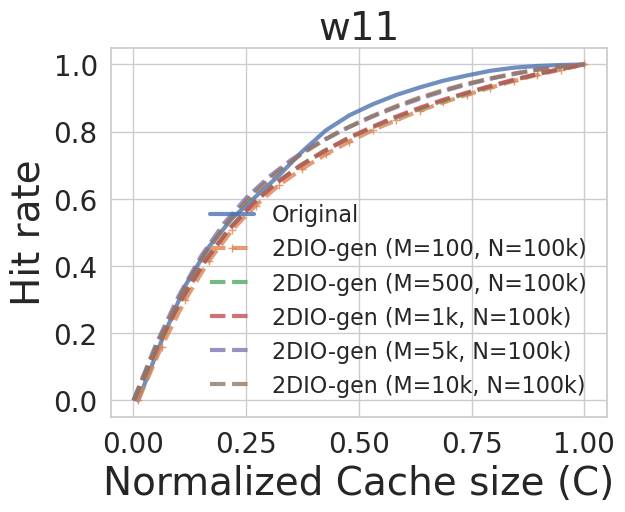

[0, 0.04324989492846209, 0.03901375825050305, 0.03895168383616849, 0.01744211673713702, 0.018839724179814953]


In [85]:
fix_n_vary_m('w11', 100000, [100, 500, 1000, 5000, 10000], f11, 1.0)

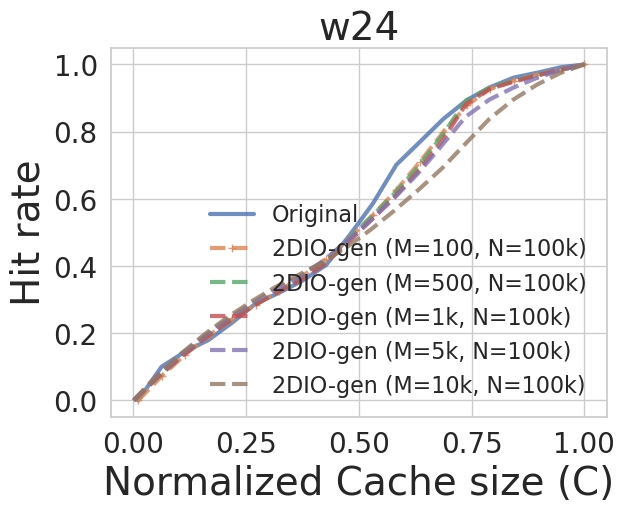

[0, 0.017964237686039983, 0.018361589451396248, 0.021805812458861235, 0.028813773960749817, 0.05017057709006266]


In [86]:
fix_n_vary_m('w24', 100000, [100, 500, 1000, 5000, 10000], f24, 0.45)

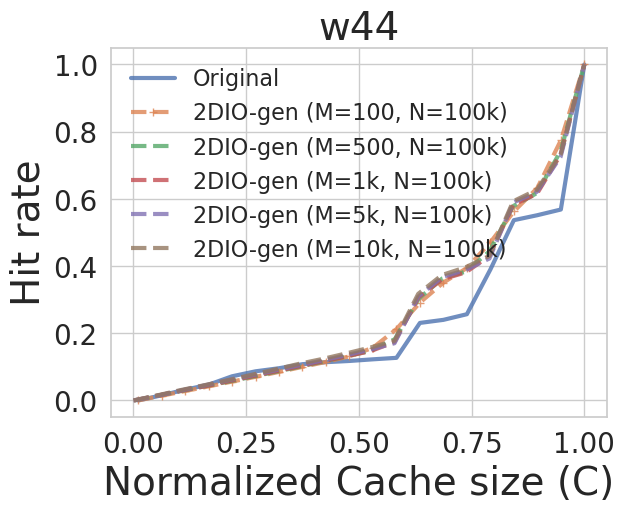

[0, 0.04492108404779323, 0.04066819037229483, 0.03881335847208385, 0.03914969028947304, 0.042159356740635034]


In [88]:
fix_n_vary_m('w44', 100000, [100, 500, 1000, 5000, 10000], f44, 0.0)

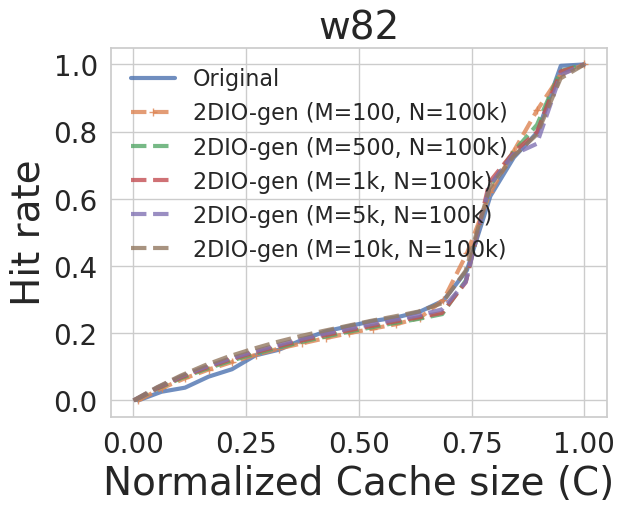

[0, 0.018655629949809207, 0.017175899762417617, 0.01649200069828961, 0.01668172242563227, 0.012666439062452971]


In [89]:
fix_n_vary_m('w82', 100000, [100, 500, 1000, 5000, 10000], f82, 0.2)

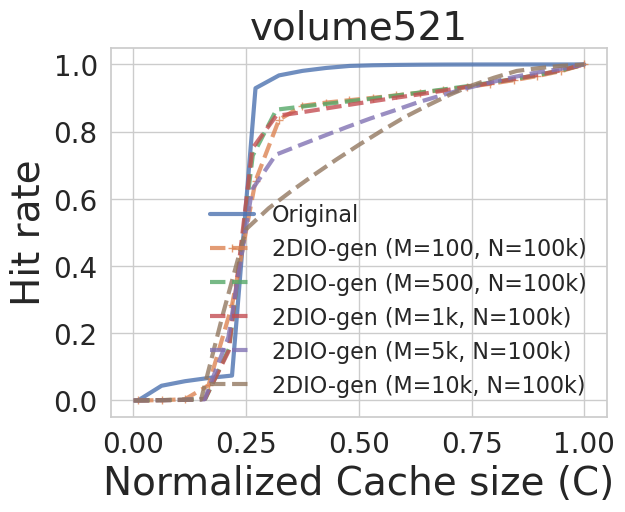

[0, 0.0808198991546196, 0.07128562438324183, 0.07427891092344518, 0.10582886024965794, 0.13438269165832686]


In [90]:
fix_n_vary_m('v521', 100000, [100, 500, 1000, 5000, 10000], pdf521, 0.0)

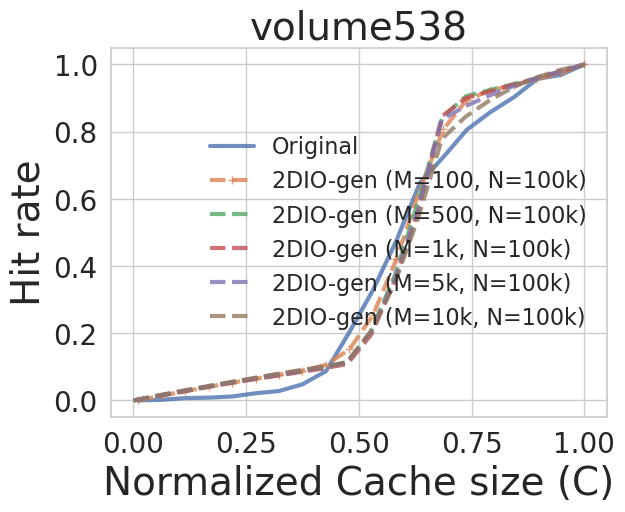

[0, 0.03695816541249171, 0.046852690047458484, 0.04943005870256407, 0.046880930482672216, 0.04411345953665767]


In [91]:
fix_n_vary_m('v538', 100000, [100, 500, 1000, 5000, 10000], pdf538, 0.1)

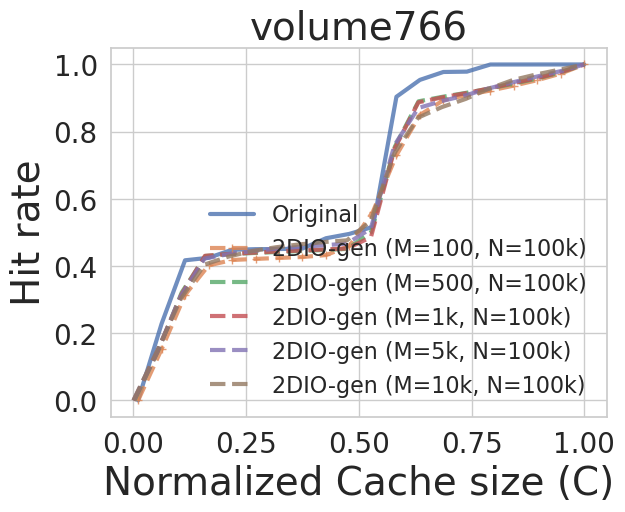

[0, 0.054479315722524915, 0.04312978640087028, 0.0443137143117653, 0.04166776067392626, 0.04667755057046288]


In [92]:
fix_n_vary_m('v766', 100000, [100, 500, 1000, 5000, 10000], f766, 0.0)

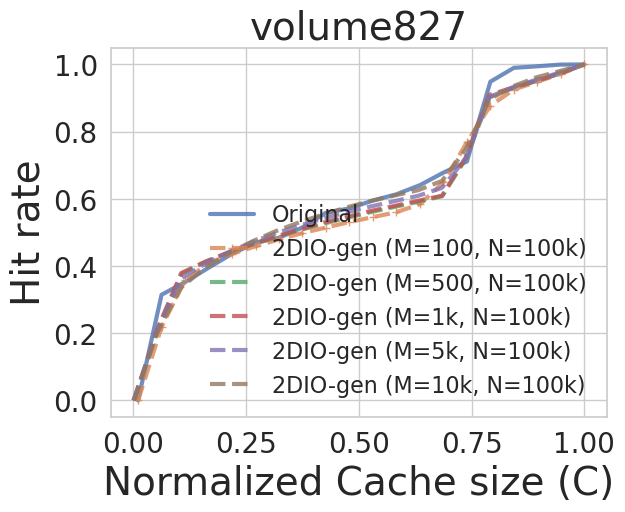

[0, 0.034300309929638464, 0.029929599491572017, 0.028795776234649552, 0.023558900097688035, 0.020905669270693414]


In [93]:
fix_n_vary_m('v827', 100000, [100, 500, 1000, 5000, 10000], f827, 0.2)

In [ ]:
mae_w11_fix_n = [0, 0.04324989492846209, 0.03901375825050305, 0.03895168383616849, 0.01744211673713702, 0.018839724179814953]
mae_w24_fix_n = [0, 0.017964237686039983, 0.018361589451396248, 0.021805812458861235, 0.028813773960749817, 0.05017057709006266]
mae_w44_fix_n = [0, 0.04492108404779323, 0.04066819037229483, 0.03881335847208385, 0.03914969028947304, 0.042159356740635034]
mae_w82_fix_n = [0, 0.018655629949809207, 0.017175899762417617, 0.01649200069828961, 0.01668172242563227, 0.012666439062452971]
mae_v521_fix_n = [0, 0.0808198991546196, 0.07128562438324183, 0.07427891092344518, 0.10582886024965794, 0.13438269165832686]
mae_v538_fix_n = [0, 0.03695816541249171, 0.046852690047458484, 0.04943005870256407, 0.046880930482672216, 0.04411345953665767]
mae_v766_fix_n = [0, 0.054479315722524915, 0.04312978640087028, 0.0443137143117653, 0.04166776067392626, 0.04667755057046288]
mae_v827_fix_n = [0, 0.034300309929638464, 0.029929599491572017, 0.028795776234649552, 0.023558900097688035, 0.020905669270693414]


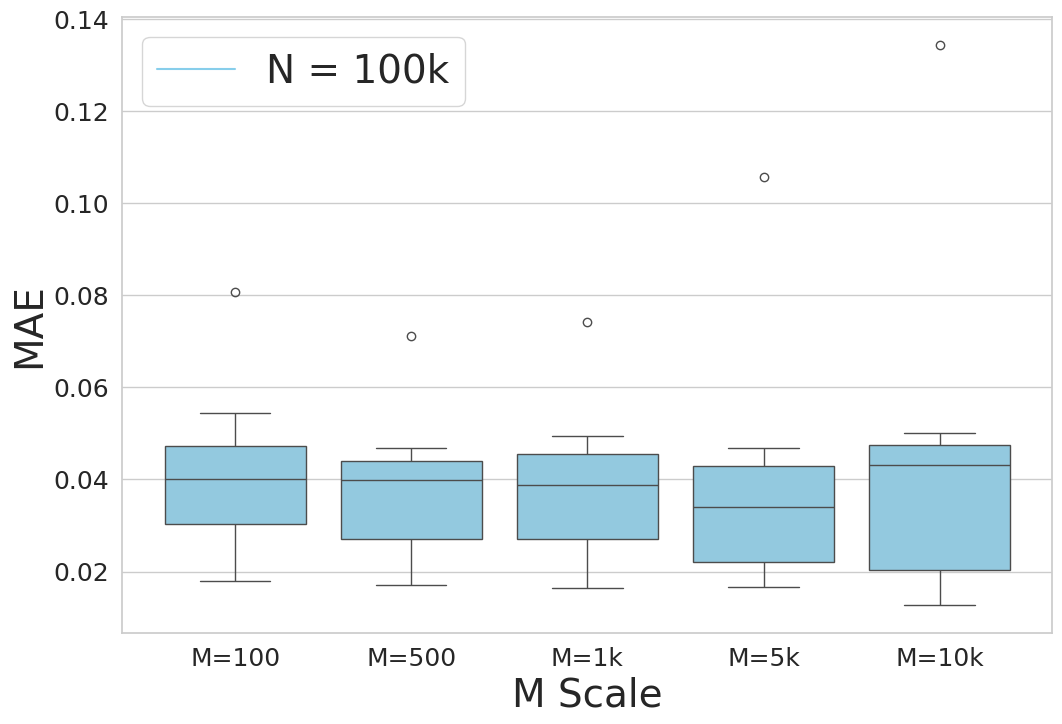

In [94]:
data_fix_n = {
    "Baseline": [0, 0, 0, 0, 0, 0, 0, 0],
    "M=100": [
        0.04324989492846209, 0.017964237686039983, 0.04492108404779323, 
        0.018655629949809207, 0.0808198991546196, 0.03695816541249171, 
        0.054479315722524915, 0.034300309929638464
    ],
    "M=500": [
        0.03901375825050305, 0.018361589451396248, 0.04066819037229483, 
        0.017175899762417617, 0.07128562438324183, 0.046852690047458484, 
        0.04312978640087028, 0.029929599491572017
    ],
    "M=1k": [
        0.03895168383616849, 0.021805812458861235, 0.03881335847208385, 
        0.01649200069828961, 0.07427891092344518, 0.04943005870256407, 
        0.0443137143117653, 0.028795776234649552
    ],
    "M=5k": [
        0.01744211673713702, 0.028813773960749817, 0.03914969028947304, 
        0.01668172242563227, 0.10582886024965794, 0.046880930482672216, 
        0.04166776067392626, 0.023558900097688035
    ],
    "M=10k": [
        0.018839724179814953, 0.05017057709006266, 0.042159356740635034, 
        0.012666439062452971, 0.13438269165832686, 0.04411345953665767, 
        0.04667755057046288, 0.020905669270693414
    ],
}
df = pd.DataFrame(data_fix_n)
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop(columns=["Baseline"]), color="skyblue")

plt.plot([], [], color="skyblue", label="N = 100k")
plt.legend(fontsize=28)

plt.ylabel("MAE", fontsize=28)
plt.xlabel("M Scale", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()